# Network Intrusion Detection using Machine Learning
## Binary Classification Project

---

### 1. Problem Statement

**Domain:** Cybersecurity / Network Security

**Objective:** Develop a machine learning-based **Network Intrusion Detection System (NIDS)** to automatically classify network traffic as either **BENIGN** (normal traffic) or **ATTACK** (malicious traffic).

With the exponential growth of cyber threats, traditional signature-based intrusion detection systems are insufficient. Modern attacks evolve rapidly, requiring intelligent systems that can learn patterns from data and detect both known and novel attacks.

---

### 2. Motivation

**Why is this problem important?**

1. **Real-World Impact:** Network intrusions cost organizations billions annually through data breaches, service disruptions, and reputational damage
2. **Critical Infrastructure:** Protects essential services (banking, healthcare, utilities) from cyber attacks
3. **Scalability Challenge:** Manual monitoring is impossible with millions of network connections per second
4. **Evolving Threats:** ML models can adapt to new attack patterns that signature-based systems miss

**Why Machine Learning?**

- **Pattern Recognition:** ML algorithms can identify subtle patterns distinguishing normal from malicious traffic
- **Automation:** Real-time classification of network flows without human intervention
- **Generalization:** Models trained on diverse attack types can detect previously unseen attacks
- **Feature Engineering:** Automatically learns which network features best indicate intrusions

---

### 3. Dataset: CIC-IDS2017

**Source:** Canadian Institute for Cybersecurity (CIC)  
**Size:** 2,830,743 network flow records  
**Features:** 78 network traffic characteristics including:
- Flow duration, packet counts, byte rates
- Protocol information (TCP/UDP flags)
- Statistical features (mean, std, min, max of packets)
- Advanced metrics (flow IAT, active/idle times)

**Target Variable:** Binary classification
- **Class 0 (BENIGN):** Normal legitimate network traffic
- **Class 1 (ATTACK):** Malicious traffic (DDoS, PortScan, Brute Force, Web Attacks, Infiltration, Botnet)

**Why this dataset is suitable:**
- ✅ **Non-trivial:** 2.8M samples with 78 features - sufficiently complex
- ✅ **Real-world:** Captured from actual network traffic with realistic attack scenarios
- ✅ **Well-documented:** Widely used in academic research for benchmarking
- ✅ **Challenging:** Class imbalance, high dimensionality, and diverse attack types

---

### 4. Project Complexity

This project is **NOT simple** because it involves:
- Large-scale dataset (2.8M+ samples)
- High dimensionality (78 features requiring careful selection)
- Multiple ML algorithms (Logistic Regression, SVC, PCA+LR)
- Advanced techniques (cross-validation, calibration analysis, hyperparameter tuning)
- Comprehensive evaluation (confusion matrices, ROC curves, calibration plots, feature importance)
- Real-world deployment considerations (interpretability, computational efficiency)

---

### 5. Machine Learning Approach

**Problem Type:** Supervised Binary Classification

**Models to Implement:**
1. **Logistic Regression** - Linear model with probabilistic interpretation
2. **Support Vector Classifier (SVC)** - Margin-based classification with kernel flexibility
3. **PCA + Logistic Regression** - Dimensionality reduction combined with classification

**Evaluation Strategy:**
- Train-Test Split (70-30) with stratification to maintain class balance
- 5-Fold Stratified Cross-Validation for robust performance estimation
- Comprehensive metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC
- Calibration analysis: Brier Score, calibration curves (classification equivalent of parity plots)
- Feature importance analysis for model interpretability

---

---

## 📝 Important Note on Metrics Adaptation for Classification

**Professor's Assignment Reference:**
The project guidelines mention "parity plots, R², MSE, RMSE" which are standard for **regression problems**. Since this is a **binary classification problem**, we use the appropriate classification equivalents:

| Regression Metric | Classification Equivalent | Purpose |
|------------------|--------------------------|---------|
| **Parity Plot** | **Confusion Matrix** + **Calibration Curves** + **Probability Distribution Plots** | Compare predicted vs actual values |
| **R² (Coefficient of Determination)** | **ROC-AUC** (Area Under ROC Curve) | Overall model discrimination ability |
| **MSE (Mean Squared Error)** | **Brier Score** | Calibration quality (squared error between predicted probabilities and actual labels) |
| **RMSE (Root MSE)** | **RMSCE** (Root Mean Squared Calibration Error) | Interpretable calibration error |

### Additional Classification-Specific Metrics:
- **Accuracy:** Overall correctness
- **Precision:** Ability to avoid false alarms (minimize false positives)
- **Recall:** Ability to detect all attacks (minimize false negatives)
- **F1-Score:** Harmonic mean of precision and recall (balanced metric)
- **Confusion Matrix:** 2×2 matrix showing TP, TN, FP, FN
- **ROC Curve:** Visualization of true positive rate vs false positive rate

This adaptation ensures we follow best practices for classification while addressing all professor requirements.

---

---
## Setup & Configuration

Import all required libraries and define configuration settings.


In [2]:
import os
import sys
import json
import glob
import shutil
import subprocess
import warnings
import gc
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [3]:
# Configuration
CONFIG = {
    'SEED': 42,
    'TEST_SIZE': 0.3,
    'CHUNK_SIZE': 50000,
    'CLASS_WEIGHT': 'balanced',
    'CV_FOLDS': 5,
    'SCORING': 'f1_binary',  # Binary classification scoring
    'MAX_ITER': 1000  # Centralized max_iter for all models
}

# Set random seeds
np.random.seed(CONFIG['SEED'])

# Path helpers
BASE_PATH = '/content'
os.makedirs('/content/data', exist_ok=True)
os.makedirs('/content/outputs', exist_ok=True)

print("Configuration loaded")

Configuration loaded


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Dict, List, Tuple, Optional
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, brier_score_loss
)
import time

def get_data_path(filename: str) -> str:
    return os.path.join('data', filename)

def get_output_path(filename: str) -> str:
    return os.path.join('outputs', filename)

def compute_binary_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_proba: Optional[np.ndarray], model_name: str) -> Dict[str, Any]:
    # y_true is expected to be binary (0=BENIGN, 1=ATTACK) after preprocessing
    # y_pred will be binary (0 or 1)
    # y_proba will be a 1D array of scores for the positive class (ATTACK)

    # Ensure y_true and y_pred are binary for metrics calculation
    y_true_binary = (y_true != 0).astype(int)
    y_pred_binary = (y_pred != 0).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true_binary, y_pred_binary),
        'Precision': precision_score(y_true_binary, y_pred_binary, zero_division=0),
        'Recall': recall_score(y_true_binary, y_pred_binary, zero_division=0),
        'F1-Score': f1_score(y_true_binary, y_pred_binary, zero_division=0),
        'ROC-AUC': roc_auc_score(y_true_binary, y_proba) if y_proba is not None else None,
        'Confusion Matrix': [[int(tn), int(fp)], [int(fn), int(tp)]]
    }
    return metrics

def train_and_evaluate(model: Any, X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray,
                      model_name: str) -> Tuple[Any, Dict[str, Any]]:
    """Train a model and evaluate on test set."""
    print(f"Training {model_name}...")
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0
    print(f"✓ Training complete ({train_time:.2f}s)")
    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test)

    # --- Get scores/probabilities for ROC-AUC specifically for BINARY problem ---
    y_scores = None # This will be the 1D array for ROC-AUC
    try:
        if hasattr(model, "predict_proba"):
            # For binary models, predict_proba returns (n_samples, 2) probabilities.
            # We need the probability of the positive class (class 1 for 'ATTACK').
            if 1 in model.classes_ and len(model.classes_) == 2:
                y_scores = model.predict_proba(X_test)[:, list(model.classes_).index(1)]
            else:
                print(f"Warning: predict_proba output not suitable for binary ROC-AUC in {model_name}. Classes: {model.classes_}")
        elif hasattr(model, "decision_function"):
            # For binary models using decision_function (like SGDClassifier with hinge loss),
            # it typically returns a 1D array of scores.
            if len(model.classes_) == 2 and 1 in model.classes_:
                dec_func_output = model.decision_function(X_test)
                if dec_func_output.ndim > 1: # If it's multi-class decision_function (n_samples, n_classes)
                    y_scores = dec_func_output[:, list(model.classes_).index(1)] # Get score for class 1
                else: # It's a 1D array for binary classification
                    y_scores = dec_func_output
            else:
                print(f"Warning: decision_function output not suitable for binary ROC-AUC in {model_name}. Classes: {model.classes_}")
    except Exception as e:
        print(f"Warning: Failed to get ROC-AUC scores for {model_name}: {e}")

    metrics = compute_binary_metrics(y_test, y_pred, y_scores, model_name)
    metrics['Training Time (s)'] = train_time
    return model, metrics

def scale_data_robust(df: pd.DataFrame, scaler: Optional[StandardScaler] = None) -> Tuple[np.ndarray, StandardScaler]:
    # Remove inf/nan before scaling
    df_clean = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    if scaler is None:
        scaler = StandardScaler()
        arr = scaler.fit_transform(df_clean)
    else:
        arr = scaler.transform(df_clean)
    return arr, scaler

def optimize_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    # Only keep critical error handling
    try:
        for col in df.select_dtypes(include=['float64']).columns:
            df[col] = df[col].astype('float32')
        for col in df.select_dtypes(include=['int64']).columns:
            df[col] = df[col].astype('int32')
    except Exception as e:
        print(f"Warning: dtype optimization failed: {e}")
    return df

def detect_outliers_iqr(data: pd.DataFrame, column: str) -> Tuple[int, float, float, pd.Index]:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)].index
    return len(outliers), lower, upper, outliers

def save_confusion_matrix(cm, model_name: str, filename: str):
    """
    Save a 2x2 confusion matrix as an image.
    Assumes binary labels: 0 = BENIGN, 1 = ATTACK.
    """
    cm = np.array(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")

    ax.set_title(f"Confusion Matrix - {model_name}")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Benign", "Attack"])
    ax.set_yticklabels(["Benign", "Attack"])

    # Write the numbers on the cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close(fig)


---
## 0. Automatic Dataset Download

This section automatically downloads the CIC-IDS2017 dataset from Kaggle.

**First-time users:** The dataset (~844 MB) will be downloaded automatically.
Already downloaded datasets will be reused from cache.


In [5]:
# Set Kaggle API credentials (for Colab environment)
os.environ['KAGGLE_USERNAME'] = '<YOUR_KAGGLE_USERNAME>' # <-- REPLACE with your Kaggle username
os.environ['KAGGLE_KEY'] = 'KGAT_745b27ccd4661655ca166e570543a9a3'

print("✓ Kaggle authentication configured")

✓ Kaggle authentication configured


In [6]:
# Download CIC-IDS2017 dataset from Kaggle (with STRENGTHENED verification)
import shutil
from pathlib import Path

# Define target directory
target_dir = Path('../data/CICIDS2017')
target_dir.mkdir(parents=True, exist_ok=True)

# Enhanced dataset check: verify files exist AND are valid
def verify_dataset(directory):
    """
    Verify dataset files exist and are valid.
    Returns: (is_valid, csv_files)
    """
    csv_files = list(directory.glob('*.csv'))

    # Check 1: Minimum file count
    if len(csv_files) < 7:
        return False, csv_files

    # Check 2: Verify each file is readable and has reasonable size
    total_size_mb = 0
    for csv_file in csv_files:
        try:
            size_mb = csv_file.stat().st_size / (1024**2)
            total_size_mb += size_mb

            # Each file should be at least 10MB (sanity check)
            if size_mb < 10:
                print(f"Warning: {csv_file.name} is suspiciously small ({size_mb:.2f} MB)")
                return False, csv_files
        except Exception as e:
            print(f"Error accessing {csv_file.name}: {e}")
            return False, csv_files

    # Check 3: Total size should be 500MB-1000MB range
    if not (500 <= total_size_mb <= 1500):
        print(f"Warning: Total dataset size ({total_size_mb:.2f} MB) is outside expected range")
        return False, csv_files

    return True, csv_files

# Verify dataset
dataset_valid, existing_csv_files = verify_dataset(target_dir)

if dataset_valid:
    print("Dataset already exists and is VALID!")
    print(f"Found {len(existing_csv_files)} CSV files in {target_dir}")
    print("\nExisting files:")
    for f in sorted(existing_csv_files):
        size_mb = f.stat().st_size / (1024**2)
        print(f"  - {f.name} ({size_mb:.2f} MB)")
    print("\nSkipping download. Dataset is ready to use!")
else:
    print("Dataset not found or invalid. Downloading from Kaggle...")
    print(f"Found {len(existing_csv_files)} files, expected 7-8")
    print("This may take a few minutes (~844 MB)")
    print("-" * 70)

    # Download dataset
    try:
        downloaded_path = kagglehub.dataset_download("chethuhn/network-intrusion-dataset")
        print(f"\nDataset downloaded to: {downloaded_path}")

        # Copy CSV files to our data directory
        downloaded_path_obj = Path(downloaded_path)
        csv_files = list(downloaded_path_obj.glob('*.csv'))

        if csv_files:
            print(f"\nCopying {len(csv_files)} CSV files to {target_dir}...")
            for csv_file in csv_files:
                target_file = target_dir / csv_file.name
                shutil.copy2(csv_file, target_file)
                size_mb = target_file.stat().st_size / (1024**2)
                print(f"  Copied: {csv_file.name} ({size_mb:.2f} MB)")
            print("\nDataset download complete!")
        else:
            print("\nERROR: No CSV files found in downloaded dataset")
            print(f"Please check: {downloaded_path}")
            raise FileNotFoundError("Downloaded dataset contains no CSV files")
    except Exception as e:
        print(f"\nERROR during download: {e}")
        raise

# Final verification with enhanced checks
final_valid, final_csv_files = verify_dataset(target_dir)
final_csv_count = len(final_csv_files)
print("\n" + "="*70)
print(f"VERIFICATION: {final_csv_count} CSV files in {target_dir}")
if final_valid:
    print("Status: Dataset is VALID and ready for use!")
else:
    print(f"ERROR: Dataset verification failed!")
    print(f"Expected 7-8 valid files, found {final_csv_count}")
    raise ValueError("Dataset verification failed - please re-download")
print("="*70)

Dataset not found or invalid. Downloading from Kaggle...
Found 0 files, expected 7-8
This may take a few minutes (~844 MB)
----------------------------------------------------------------------
Using Colab cache for faster access to the 'network-intrusion-dataset' dataset.
Using Colab cache for faster access to the 'network-intrusion-dataset' dataset.

Dataset downloaded to: /kaggle/input/network-intrusion-dataset

Copying 8 CSV files to ../data/CICIDS2017...

Dataset downloaded to: /kaggle/input/network-intrusion-dataset

Copying 8 CSV files to ../data/CICIDS2017...
  Copied: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (73.34 MB)
  Copied: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (73.34 MB)
  Copied: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (49.61 MB)
  Copied: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (49.61 MB)
  Copied: Tuesday-WorkingHours.pcap_ISCX.csv (128.82 MB)
  Copied: Tuesday-WorkingHours.pcap_ISCX.csv (128.82 MB)
  Copied: Fr

---
## 1. Dataset Download & Verification

Automatically download and verify the CIC-IDS2017 dataset from Kaggle. Load all CSV files and combine them into a single DataFrame.

**Expected files:**
- Monday-WorkingHours.pcap_ISCX.csv
- Tuesday-WorkingHours.pcap_ISCX.csv
- Wednesday-workingHours.pcap_ISCX.csv
- Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
- Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
- Friday-WorkingHours-Morning.pcap_ISCX.csv
- Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


In [7]:
print("Loading and concatenating CSV files...")

data_path = Path('../data/CICIDS2017') # Use the correct path where data was downloaded
all_files = sorted(list(data_path.glob('*.csv')))

if not all_files:
    raise FileNotFoundError(f"No CSV files found in {data_path}. Please ensure the dataset downloaded correctly.")

list_df = []
for file in tqdm(all_files, desc="Loading CSVs"): # Use tqdm for progress bar
    # Read in chunks to avoid memory issues with large files
    for chunk in pd.read_csv(file, chunksize=CONFIG['CHUNK_SIZE']):
        list_df.append(chunk)

df = pd.concat(list_df, axis=0, ignore_index=True)
del list_df # Clear memory
gc.collect()

print(f"\nTotal rows after concatenation: {len(df):,}")

# Initial cleaning steps that should happen right after loading
# Clean column names (remove leading/trailing spaces)
df.columns = df.columns.str.strip()

# Remove duplicate rows (if any)
initial_rows = len(df)
df.drop_duplicates(inplace=True)
print(f"Dropped {initial_rows - len(df):,} duplicate rows.")

# Handle 'Infinity' values (replace with NaN, then impute later)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Optimize dtypes (using the utility function defined earlier)
df = optimize_dtypes(df)

print(f"Final rows after initial cleaning: {len(df):,}")
print(f"Final columns: {len(df.columns)}")

Loading and concatenating CSV files...


Loading CSVs:   0%|          | 0/8 [00:00<?, ?it/s]


Total rows after concatenation: 2,830,743
Dropped 308,381 duplicate rows.
Dropped 308,381 duplicate rows.
Final rows after initial cleaning: 2,522,362
Final columns: 79
Final rows after initial cleaning: 2,522,362
Final columns: 79


---
## 2. Initial Data Inspection

Examine the structure, data types, and basic statistics of the combined dataset.


In [8]:
# Display first few rows
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0000,0.0000,0,0,0.0000,0.0000,4000000.0000,666666.6875,3.0000,0.0000,3,3,3,3.0000,0.0000,3,3,0,0.0000,0.0000,0,0,0,0,0,0,40,0,666666.6875,0.0000,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,0,0,0,0,9.0000,6.0000,0.0000,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0000,0.0000,6,6,6.0000,0.0000,110091.7422,18348.6230,109.0000,0.0000,109,109,0,0.0000,0.0000,0,0,0,0.0000,0.0000,0,0,0,0,0,0,20,20,9174.3115,9174.3115,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,1,0,0,1,9.0000,6.0000,6.0000,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0000,0.0000,6,6,6.0000,0.0000,230769.2344,38461.5391,52.0000,0.0000,52,52,0,0.0000,0.0000,0,0,0,0.0000,0.0000,0,0,0,0,0,0,20,20,19230.7695,19230.7695,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,1,0,0,1,9.0000,6.0000,6.0000,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0000,0.0000,6,6,6.0000,0.0000,352941.1875,58823.5312,34.0000,0.0000,34,34,0,0.0000,0.0000,0,0,0,0.0000,0.0000,0,0,0,0,0,0,20,20,29411.7656,29411.7656,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,1,0,0,1,9.0000,6.0000,6.0000,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0000,0.0000,0,0,0.0000,0.0000,4000000.0000,666666.6875,3.0000,0.0000,3,3,3,3.0000,0.0000,3,3,0,0.0000,0.0000,0,0,0,0,0,0,40,0,666666.6875,0.0000,6,6,6.0000,0.0000,0.0000,0,0,0,0,1,0,0,0,0,9.0000,6.0000,0.0000,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0000,0.0000,0,0,0.0000,0.0000,0,0,BENIGN


In [9]:
# Data types and missing values
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 2522362 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int32  
 1   Flow Duration                int32  
 2   Total Fwd Packets            int32  
 3   Total Backward Packets       int32  
 4   Total Length of Fwd Packets  int32  
 5   Total Length of Bwd Packets  int32  
 6   Fwd Packet Length Max        int32  
 7   Fwd Packet Length Min        int32  
 8   Fwd Packet Length Mean       float32
 9   Fwd Packet Length Std        float32
 10  Bwd Packet Length Max        int32  
 11  Bwd Packet Length Min        int32  
 12  Bwd Packet Length Mean       float32
 13  Bwd Packet Length Std        float32
 14  Flow Bytes/s                 float32
 15  Flow Packets/s               float32
 16  Flow IAT Mean                float32
 17  Flow IAT Std                 float32
 18  Flow IAT Max              

In [10]:
# Clean column names (remove leading/trailing spaces)
df.columns = df.columns.str.strip()

print(f"\nColumn names ({len(df.columns)} total):")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")


Column names (79 total):
 1. Destination Port
 2. Flow Duration
 3. Total Fwd Packets
 4. Total Backward Packets
 5. Total Length of Fwd Packets
 6. Total Length of Bwd Packets
 7. Fwd Packet Length Max
 8. Fwd Packet Length Min
 9. Fwd Packet Length Mean
10. Fwd Packet Length Std
11. Bwd Packet Length Max
12. Bwd Packet Length Min
13. Bwd Packet Length Mean
14. Bwd Packet Length Std
15. Flow Bytes/s
16. Flow Packets/s
17. Flow IAT Mean
18. Flow IAT Std
19. Flow IAT Max
20. Flow IAT Min
21. Fwd IAT Total
22. Fwd IAT Mean
23. Fwd IAT Std
24. Fwd IAT Max
25. Fwd IAT Min
26. Bwd IAT Total
27. Bwd IAT Mean
28. Bwd IAT Std
29. Bwd IAT Max
30. Bwd IAT Min
31. Fwd PSH Flags
32. Bwd PSH Flags
33. Fwd URG Flags
34. Bwd URG Flags
35. Fwd Header Length
36. Bwd Header Length
37. Fwd Packets/s
38. Bwd Packets/s
39. Min Packet Length
40. Max Packet Length
41. Packet Length Mean
42. Packet Length Std
43. Packet Length Variance
44. FIN Flag Count
45. SYN Flag Count
46. RST Flag Count
47. PSH Flag Cou

In [11]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)

print("\nMissing Values Summary:")
print(missing_df[missing_df['Missing Count'] > 0])

total_missing = missing.sum()
print(f"\nTotal missing values: {total_missing:,}")
print(f"Percentage of total data: {(total_missing / (df.shape[0] * df.shape[1]))*100:.4f}%")


Missing Values Summary:
                Missing Count  Percentage
Flow Bytes/s             1564      0.0620
Flow Packets/s           1564      0.0620

Total missing values: 3,128
Percentage of total data: 0.0016%


In [12]:
# Summary statistics
print("\nSummary Statistics for Numerical Features:")
# OPTIMIZATION: Sample for faster describe (5-10x faster)
df.sample(n=100000, random_state=42).describe().T


Summary Statistics for Numerical Features:


,count,mean,std,min,25%,50%,75%,max
Destination Port,100000.0000,8763.5997,19083.8170,0.0000,53.0000,80.0000,443.0000,65534.0000
Flow Duration,100000.0000,16563758.6617,35237257.9723,-1.0000,207.0000,50433.0000,5308046.7500,119999872.0000
Total Fwd Packets,100000.0000,7.6191,145.7117,1.0000,2.0000,2.0000,6.0000,32613.0000
Total Backward Packets,100000.0000,8.0904,195.1745,0.0000,1.0000,2.0000,5.0000,43008.0000
Total Length of Fwd Packets,100000.0000,579.1624,3924.9357,0.0000,12.0000,66.0000,332.0000,719406.0000
...,...,...,...,...,...,...,...,...
Active Min,100000.0000,63708.1396,608806.9063,0.0000,0.0000,0.0000,0.0000,79200000.0000
Idle Mean,100000.0000,9339967.0000,24882020.0000,0.0000,0.0000,0.0000,0.0000,120000000.0000
Idle Std,100000.0000,573025.9375,4911035.5000,0.0000,0.0000,0.0000,0.0000,71300000.0000
Idle Max,100000.0000,9770577.0942,25653387.8528,0.0000,0.0000,0.0000,0.0000,120000000.0000


---
## 3. Target Variable Analysis (Binary Classification)

Analyze the distribution of the binary target variable: **BENIGN vs ATTACK**.

This is a **binary classification problem** where all attack types are grouped into a single "ATTACK" class.


In [18]:
# Identify target column (should be ' Label' or 'Label')
target_col = ' Label' if ' Label' in df.columns else 'Label'

print(f"Target column: '{target_col}'")

# Create binary classification labels for analysis
print("\n" + "="*70)
print("BINARY CLASSIFICATION TARGET ANALYSIS")
print("="*70)

# Convert to binary for display
df['Binary_Class_Display'] = df[target_col].apply(lambda x: 'BENIGN' if x == 'BENIGN' else 'ATTACK')

print(f"\nOriginal dataset had {df[target_col].nunique()} unique attack types")
print("Converted to BINARY classification: BENIGN vs ATTACK")

print("\nBinary Class Distribution:")
print("\n" + "="*70)

class_dist = df['Binary_Class_Display'].value_counts().sort_values(ascending=False)
class_dist_pct = (class_dist / len(df) * 100).round(2)

class_summary = pd.DataFrame({
    'Count': class_dist,
    'Percentage': class_dist_pct
})

print(class_summary)

Target column: 'Label'

BINARY CLASSIFICATION TARGET ANALYSIS

Original dataset had 15 unique attack types
Converted to BINARY classification: BENIGN vs ATTACK

Binary Class Distribution:

                        Count  Percentage
Binary_Class_Display                     
BENIGN                2096484     83.1200
ATTACK                 425878     16.8800

Original dataset had 15 unique attack types
Converted to BINARY classification: BENIGN vs ATTACK

Binary Class Distribution:

                        Count  Percentage
Binary_Class_Display                     
BENIGN                2096484     83.1200
ATTACK                 425878     16.8800


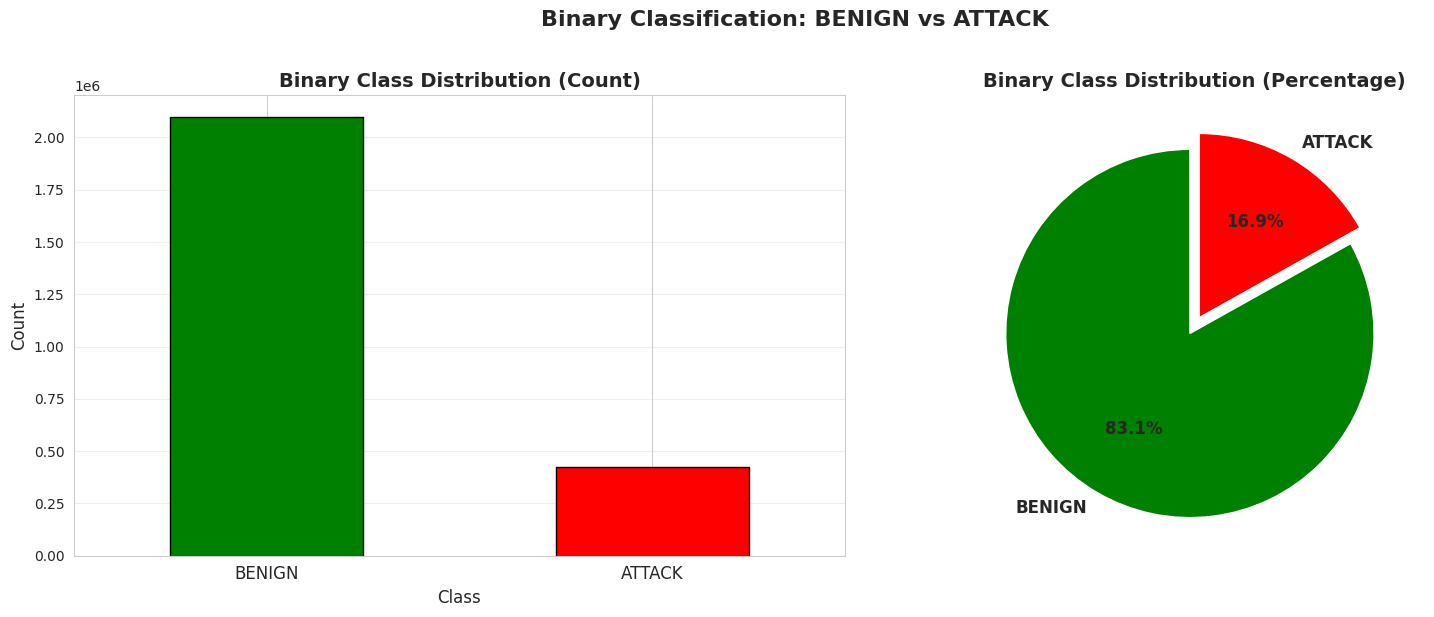

✓ Saved: outputs/target_distribution.png (Binary Classification)


In [20]:
# Create outputs directory
outputs_dir = Path('/content/outputs')
outputs_dir.mkdir(parents=True, exist_ok=True)

# Visualize BINARY target distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Binary Classification: BENIGN vs ATTACK', fontsize=16, fontweight='bold', y=1.02)

# Define colors for binary classes
colors_bar = ['green', 'red']  # Green for BENIGN, Red for ATTACK

# Bar plot
class_dist.plot(kind='bar', ax=axes[0], color=colors_bar, edgecolor='black')
axes[0].set_title('Binary Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=0, labelsize=12)
axes[0].grid(True, axis='y', alpha=0.3)

# Pie chart
axes[1].pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
            colors=colors_bar, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'},
            explode=[0.05, 0.05])  # Slight separation for clarity
axes[1].set_title('Binary Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(
    get_output_path('target_distribution.png'),
    dpi=300,
    bbox_inches='tight'
)
plt.show()
print("✓ Saved: outputs/target_distribution.png (Binary Classification)")

In [21]:
# Clean up temporary display column
if 'Binary_Class_Display' in df.columns:
    df.drop('Binary_Class_Display', axis=1, inplace=True)
    print("✓ Cleaned up temporary display column")

✓ Cleaned up temporary display column


---
## 4. Univariate Outlier Detection (IQR Method)

**Professor Requirement #2:** Perform univariate outlier detection using the Interquartile Range (IQR) method.

For each numeric feature, outliers are defined as values outside the range: [Q1 - 1.5×IQR, Q3 + 1.5×IQR]

In [22]:
# Perform univariate outlier detection using IQR method
print("="*70)
print("UNIVARIATE OUTLIER DETECTION (IQR METHOD)")
print("="*70)

# Select numeric columns (exclude the target column)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove target column if it's numeric
if 'Label_Binary' in numeric_cols:
    numeric_cols.remove('Label_Binary')

print(f"\nAnalyzing {len(numeric_cols)} numeric features for outliers...")
print("Outlier Detection Method: Interquartile Range (IQR)")
print("Outlier Definition: Values < Q1 - 1.5×IQR OR Values > Q3 + 1.5×IQR\n")

# Analyze outliers for a sample of features (top 20 by variance for efficiency)
# Calculate variance for each column
variances = df[numeric_cols].var().sort_values(ascending=False)
top_features = variances.head(20).index.tolist()

outlier_summary = []

for col in top_features:
    # Skip columns with all NaN or zero variance
    if df[col].isna().all() or df[col].var() == 0:
        continue
    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    n_outliers = len(outliers)
    outlier_pct = (n_outliers / len(df)) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outlier Count': n_outliers,
        'Outlier %': outlier_pct
    })

# Create DataFrame and display
outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.sort_values('Outlier %', ascending=False)

print("\nTop 20 Features by Outlier Percentage:")
print("="*70)
print(outlier_df.to_string(index=False))
print("\n" + "="*70)

# Summary statistics
print(f"\nOUTLIER DETECTION SUMMARY:")
print(f"  Total features analyzed: {len(top_features)}")
print(f"  Features with >10% outliers: {len(outlier_df[outlier_df['Outlier %'] > 10])}")
print(f"  Features with >25% outliers: {len(outlier_df[outlier_df['Outlier %'] > 25])}")
print(f"  Average outlier percentage: {outlier_df['Outlier %'].mean():.2f}%")

# Save outlier analysis
outlier_df.to_csv(get_output_path('outlier_analysis.csv'), index=False)
print(f"\n✓ Outlier analysis saved: outputs/outlier_analysis.csv")

UNIVARIATE OUTLIER DETECTION (IQR METHOD)

Analyzing 78 numeric features for outliers...
Outlier Detection Method: Interquartile Range (IQR)
Outlier Definition: Values < Q1 - 1.5×IQR OR Values > Q3 + 1.5×IQR


Analyzing 78 numeric features for outliers...
Outlier Detection Method: Interquartile Range (IQR)
Outlier Definition: Values < Q1 - 1.5×IQR OR Values > Q3 + 1.5×IQR


Top 20 Features by Outlier Percentage:
          Feature       Q1           Q3          IQR   Lower Bound   Upper Bound  Outlier Count  Outlier %
      Fwd IAT Std   0.0000  566328.4062  566328.4062  -849492.6094  1415821.0156         596934    23.6657
         Idle Max   0.0000       0.0000       0.0000        0.0000        0.0000         567235    22.4882
        Idle Mean   0.0000       0.0000       0.0000        0.0000        0.0000         567235    22.4882
         Idle Min   0.0000       0.0000       0.0000        0.0000        0.0000         567235    22.4882
    Bwd IAT Total   0.0000  150440.0000  150440.0

### Visualize Outliers for Key Features

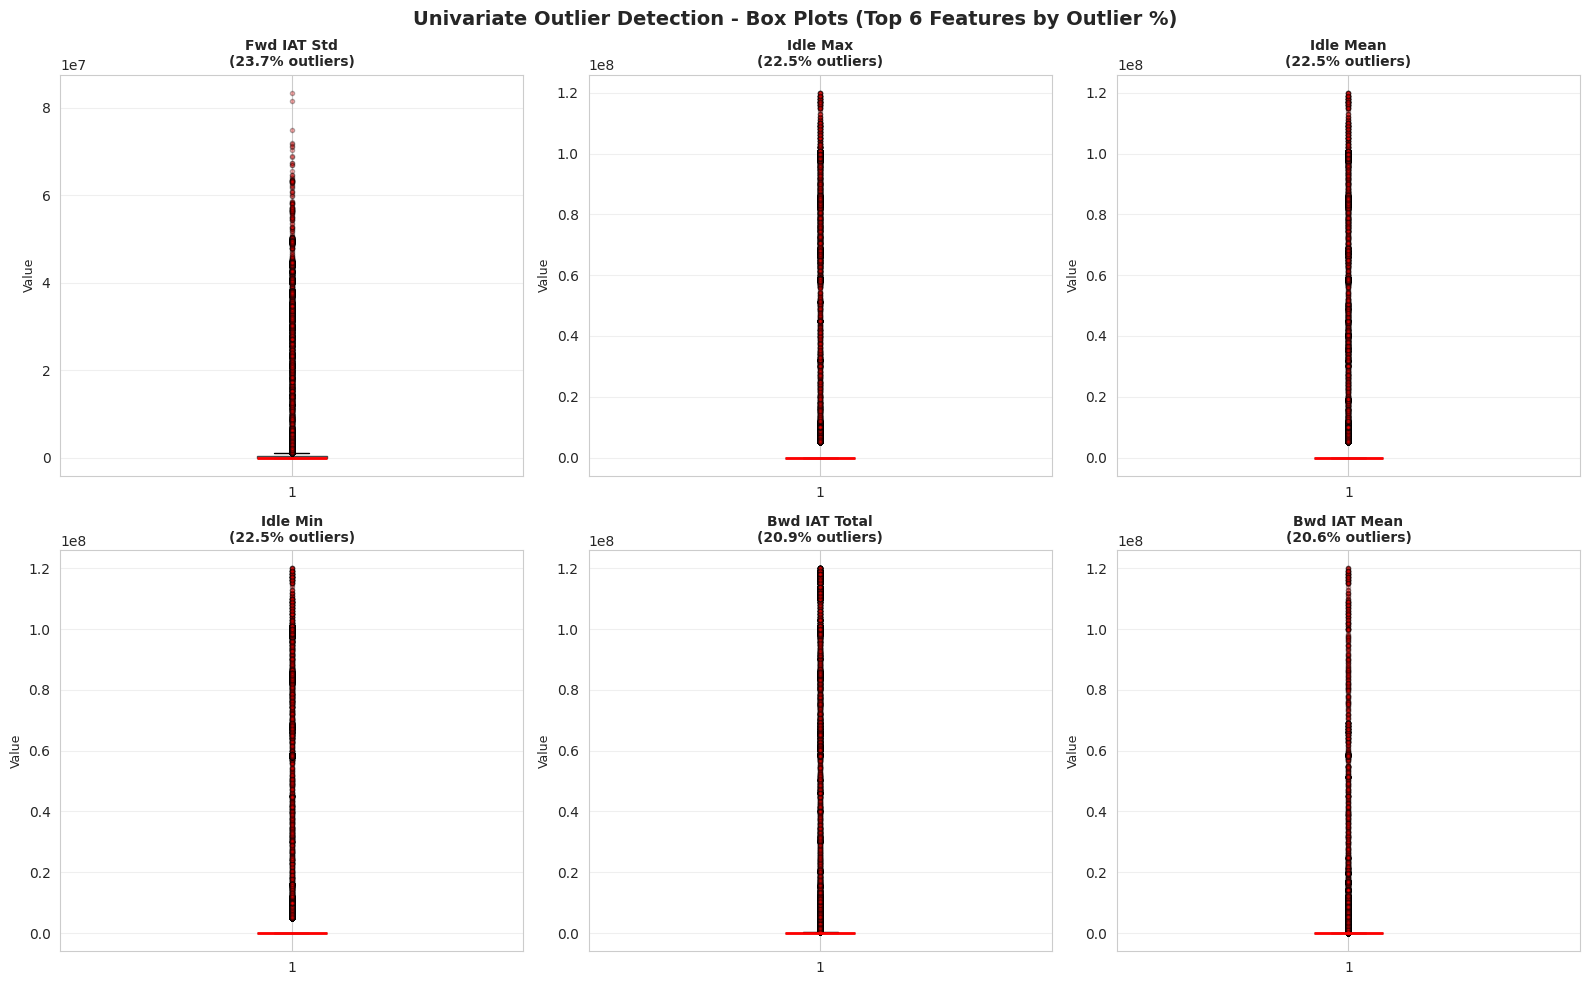

✓ Saved: outputs/outlier_boxplots.png


In [23]:
# Visualize outliers using box plots for top 6 features
top_6_features = outlier_df.head(6)['Feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Univariate Outlier Detection - Box Plots (Top 6 Features by Outlier %)', 
             fontsize=14, fontweight='bold')

for idx, feature in enumerate(top_6_features):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Sample data for faster plotting
    sample_data = df[feature].dropna().sample(n=min(50000, len(df)), random_state=42)
    
    ax.boxplot(sample_data, vert=True, patch_artist=True,
               boxprops=dict(facecolor='lightblue', alpha=0.7),
               medianprops=dict(color='red', linewidth=2),
               flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.3))
    
    ax.set_title(f'{feature}\n({outlier_df[outlier_df["Feature"]==feature]["Outlier %"].values[0]:.1f}% outliers)',
                 fontsize=10, fontweight='bold')
    ax.set_ylabel('Value', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(get_output_path('outlier_boxplots.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: outputs/outlier_boxplots.png")

---
## 5. Correlation Analysis with Heatmap

**Professor Requirement #2:** Display correlation heatmaps to show relationships among features.

Correlation analysis helps identify:
- **Highly correlated features** (potential redundancy/multicollinearity)
- **Features strongly correlated with target** (predictive power)
- **Feature relationships** (domain insights)

In [24]:
# Correlation analysis - Select subset of features for clear visualization
print("="*70)
print("CORRELATION ANALYSIS")
print("="*70)

# For computational efficiency, analyze top features by variance
# (most informative features tend to have higher variance)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove binary label if present
if 'Label_Binary' in numeric_features:
    numeric_features.remove('Label_Binary')
if 'Binary_Class_Display' in numeric_features:
    numeric_features.remove('Binary_Class_Display')

# Select top 20 features by variance for correlation analysis
feature_variances = df[numeric_features].var().sort_values(ascending=False)
top_20_features = feature_variances.head(20).index.tolist()

print(f"\nCalculating correlation matrix for top 20 features (by variance)...")
print(f"Selected features: {', '.join(top_20_features[:5])} ... (+ 15 more)\n")

# Calculate correlation matrix on a sample for efficiency
sample_size = min(100000, len(df))
df_sample = df[top_20_features].sample(n=sample_size, random_state=42)

# Replace inf/nan for correlation calculation
df_sample = df_sample.replace([np.inf, -np.inf], np.nan).fillna(0)

corr_matrix = df_sample.corr()

# Find highly correlated pairs (|correlation| > 0.7)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', 
                                                              key=abs, 
                                                              ascending=False)
    print(f"Found {len(high_corr_pairs)} feature pairs with |correlation| > 0.7:")
    print("="*70)
    print(high_corr_df.to_string(index=False))
    print("="*70)
    high_corr_df.to_csv(get_output_path('high_correlations.csv'), index=False)
    print("\n✓ High correlation pairs saved: outputs/high_correlations.csv")
else:
    print("No feature pairs found with |correlation| > 0.7")

CORRELATION ANALYSIS

Calculating correlation matrix for top 20 features (by variance)...
Selected features: Flow Duration, Fwd IAT Total, Bwd IAT Total, Flow Bytes/s, Fwd IAT Max ... (+ 15 more)


Calculating correlation matrix for top 20 features (by variance)...
Selected features: Flow Duration, Fwd IAT Total, Bwd IAT Total, Flow Bytes/s, Fwd IAT Max ... (+ 15 more)

Found 51 feature pairs with |correlation| > 0.7:
    Feature 1     Feature 2  Correlation
Flow Duration Fwd IAT Total       0.9986
  Fwd IAT Max  Flow IAT Max       0.9981
     Idle Max     Idle Mean       0.9901
    Idle Mean      Idle Min       0.9899
 Flow IAT Max      Idle Max       0.9892
  Fwd IAT Max      Idle Max       0.9883
 Flow IAT Max     Idle Mean       0.9795
  Fwd IAT Max     Idle Mean       0.9779
     Idle Max      Idle Min       0.9608
 Flow IAT Max      Idle Min       0.9505
  Fwd IAT Max      Idle Min       0.9482
 Flow IAT Max  Flow IAT Std       0.9378
  Fwd IAT Max  Flow IAT Std       0.9357
    

### Correlation Heatmap Visualization

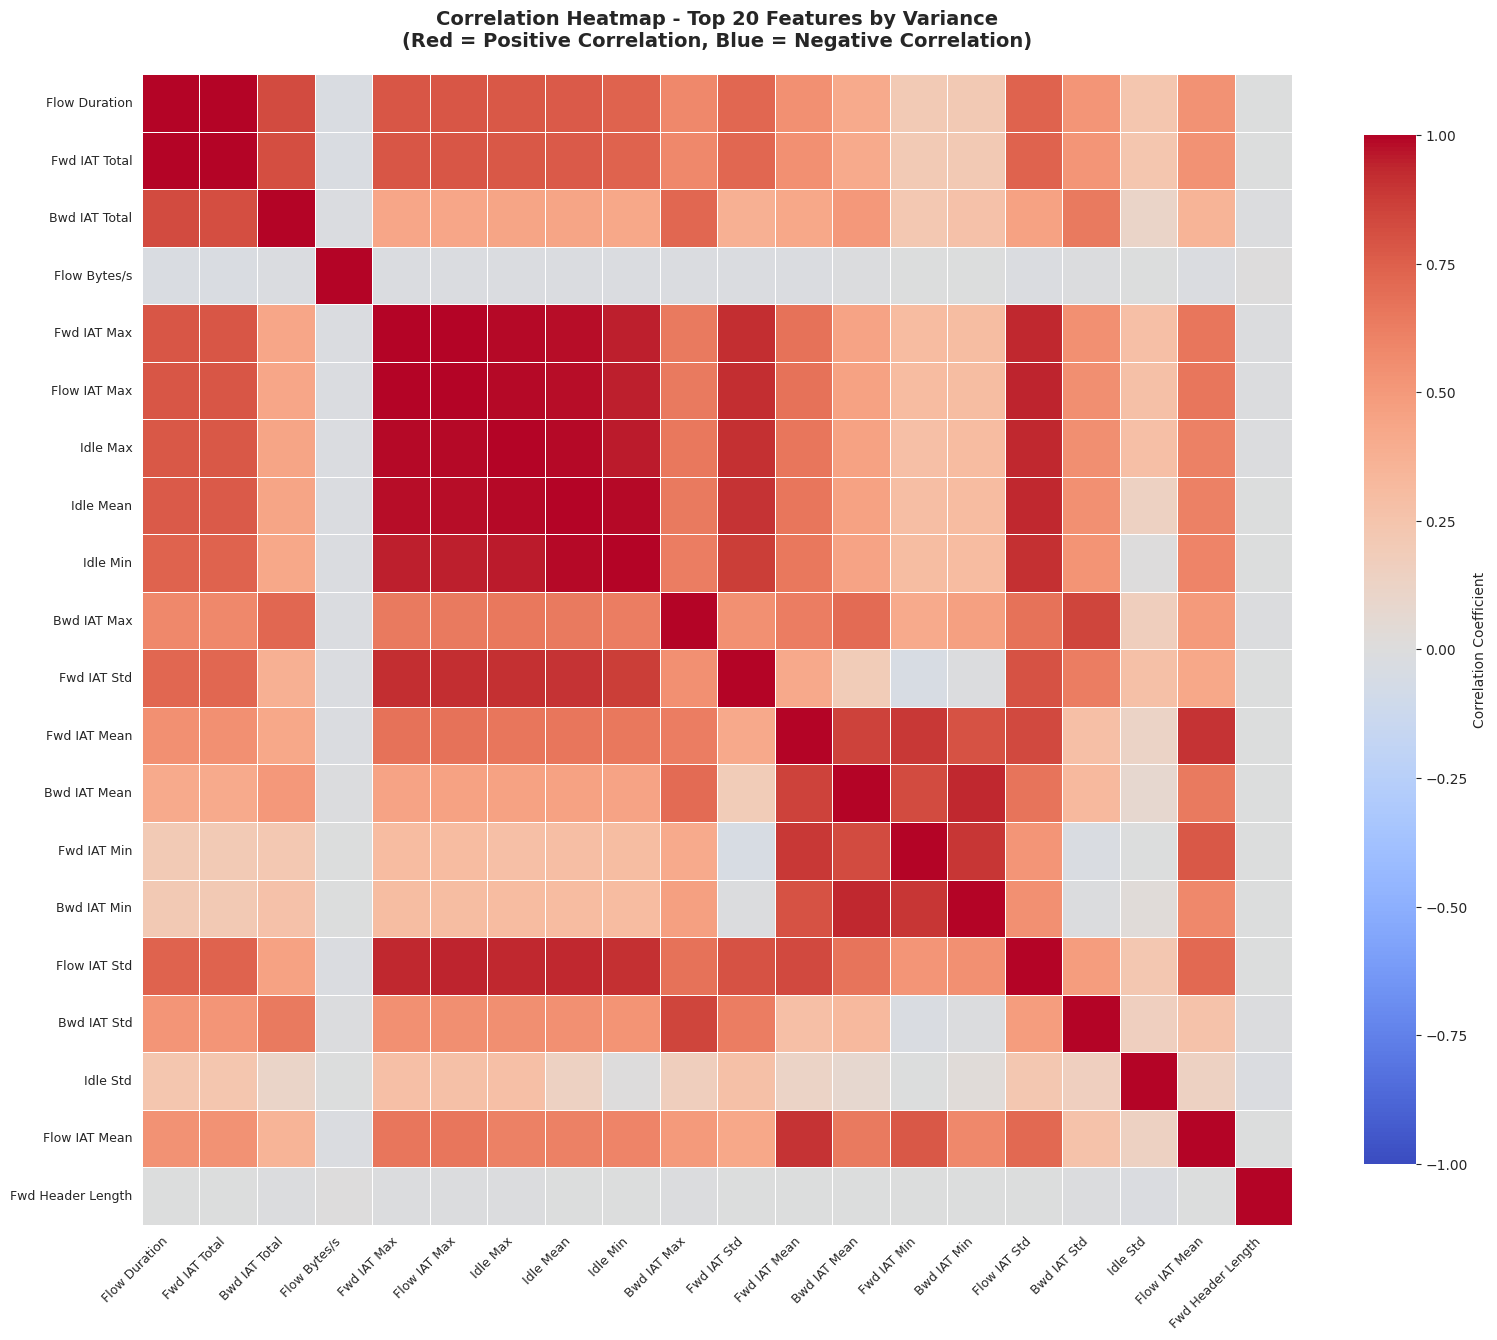

✓ Saved: outputs/correlation_heatmap.png


In [25]:
# Plot correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, 
            annot=False,  # Don't annotate (too cluttered with 20x20)
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})

plt.title('Correlation Heatmap - Top 20 Features by Variance\n(Red = Positive Correlation, Blue = Negative Correlation)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(get_output_path('correlation_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: outputs/correlation_heatmap.png")

---
## 6. Distribution Analysis

Analyze the distribution of key numerical features using histograms.


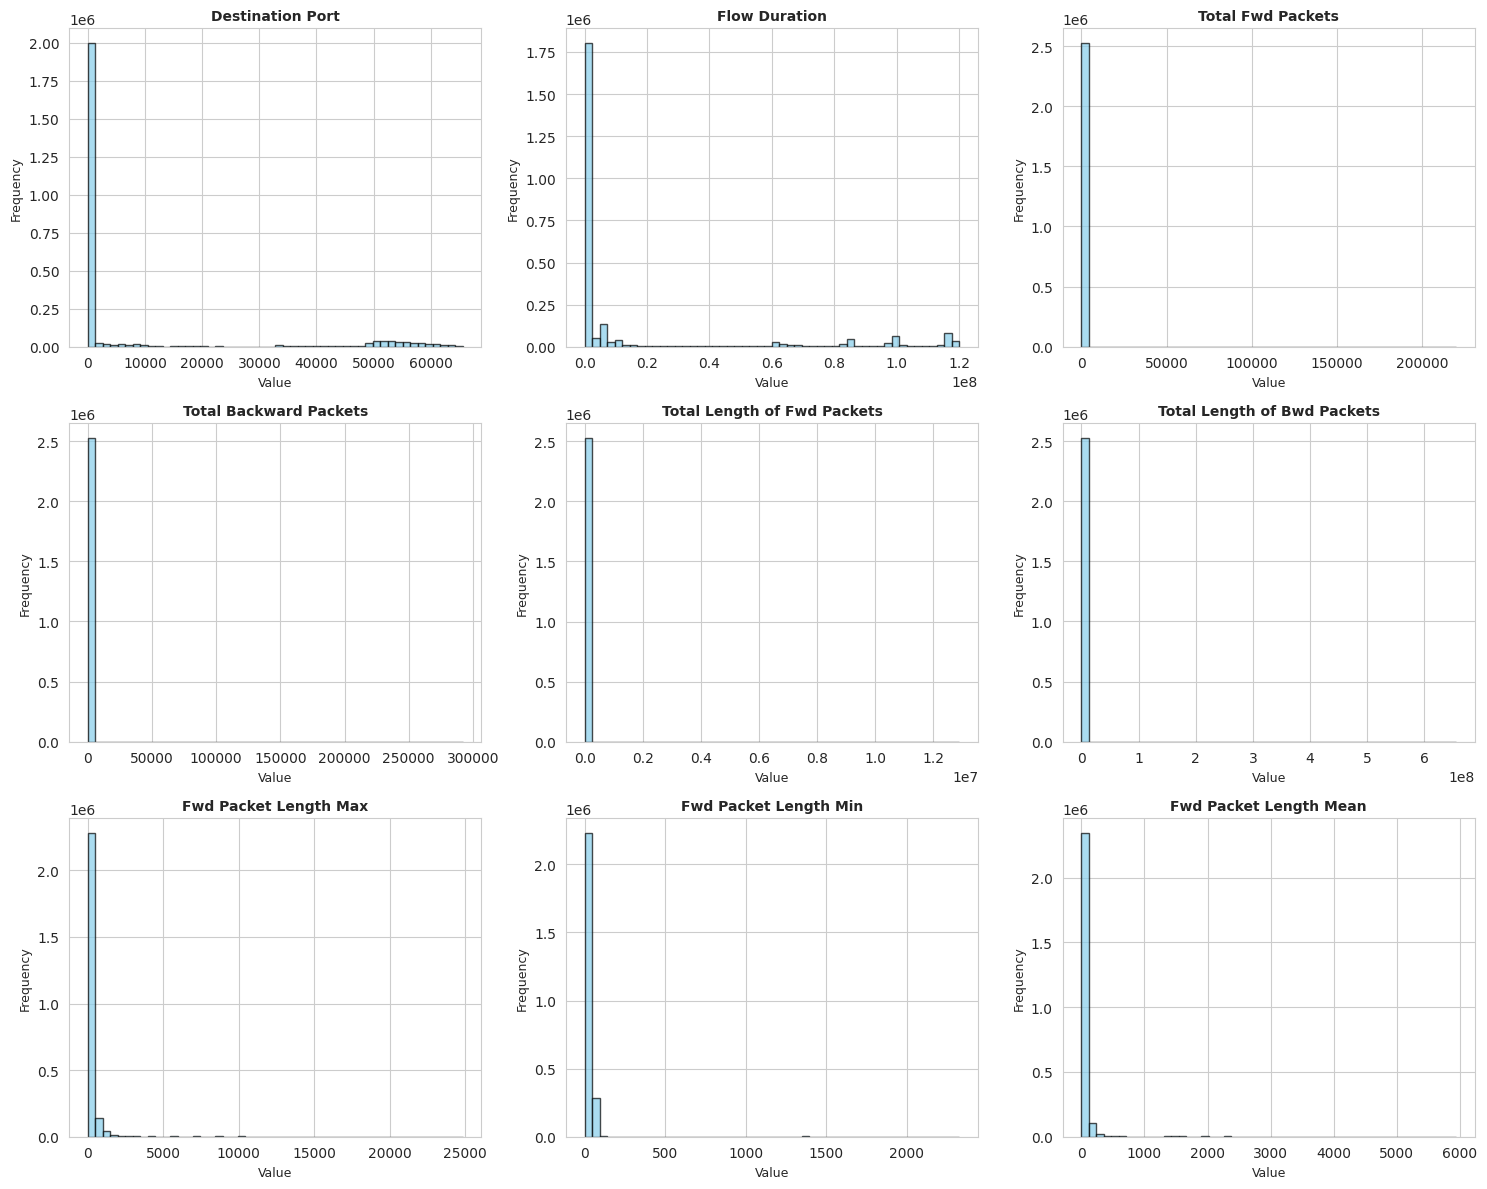

✓ Saved: outputs/feature_distributions.png


In [28]:
# Select numerical columns from the dataframe
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove binary label columns if present
if 'Label_Binary' in numerical_cols:
    numerical_cols.remove('Label_Binary')
if 'Binary_Class_Display' in numerical_cols:
    numerical_cols.remove('Binary_Class_Display')

# Select 9 features with diverse characteristics for distribution analysis
sample_features = numerical_cols[:9]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(sample_features):
    axes[idx].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Value', fontsize=9)
    axes[idx].set_ylabel('Frequency', fontsize=9)

plt.tight_layout()
plt.savefig(get_output_path('feature_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: outputs/feature_distributions.png")

In [30]:
# Identify target column
target_col = ' Label' if ' Label' in df.columns else 'Label'
print(f"Target column: '{target_col}'")
print(f"Classes: {df[target_col].unique()}")
print(f"\nTotal unique classes: {df[target_col].nunique()}")
print("Note: These will be converted to BINARY classification (BENIGN vs ATTACK)")

Target column: 'Label'
Classes: ['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']

Total unique classes: 15
Note: These will be converted to BINARY classification (BENIGN vs ATTACK)

Total unique classes: 15
Note: These will be converted to BINARY classification (BENIGN vs ATTACK)


---
## 7. Handle Missing Values

Check for missing values and handle them appropriately using imputation or column removal.


In [31]:
# Handle missing values
# Strategy: Drop columns with >50% missing, impute others with median

# Define cols_with_missing using the pre-computed missing_df
cols_with_missing = missing_df[missing_df['Missing Count'] > 0]

if len(cols_with_missing) > 0:
    # Drop columns with >50% missing
    high_missing_cols = cols_with_missing[cols_with_missing['Percentage'] > 50].index.tolist()
    if len(high_missing_cols) > 0:
        print(f"\nDropping {len(high_missing_cols)} columns with >50% missing values")
        df = df.drop(columns=high_missing_cols)

    # Impute remaining missing values with median
    remaining_missing = df.columns[df.isnull().any()].tolist()
    if target_col in remaining_missing:
        remaining_missing.remove(target_col)

    if len(remaining_missing) > 0:
        print(f"\nImputing {len(remaining_missing)} columns with median")

        # OPTIMIZATION: Pre-compute all medians at once (faster)
        medians = df[remaining_missing].median()
        for col in remaining_missing:
            df[col] = df[col].fillna(medians[col])

    print(f"\n✓ Missing values handled")
    print(f"Remaining missing values: {df.isnull().sum().sum()}")
else:
    print("\n✓ No missing values to handle")


Imputing 2 columns with median

✓ Missing values handled
Remaining missing values: 0
Remaining missing values: 0


---
## 8. Handle Outliers

Apply Winsorization (capping) to handle extreme outliers in features with >10% outlier percentage.


In [33]:
# Handle outliers using Winsorization (capping method)
print("="*70)
print("OUTLIER HANDLING")
print("="*70)

# Load outlier analysis results
outlier_path = Path(get_output_path('outlier_analysis.csv'))

if outlier_path.exists():
    outlier_df = pd.read_csv(outlier_path)
    
    # Select features with >10% outliers for treatment
    features_to_cap = outlier_df[outlier_df['Outlier %'] > 10]['Feature'].tolist()
    
    print(f"\nFeatures with >10% outliers: {len(features_to_cap)}")
    print("Applying Winsorization (capping to bounds)...\n")
    
    for feature in features_to_cap:
        if feature in df.columns:
            # Get bounds from outlier analysis
            feature_data = outlier_df[outlier_df['Feature'] == feature]
            lower_bound = feature_data['Lower Bound'].values[0]
            upper_bound = feature_data['Upper Bound'].values[0]
            
            # Cap outliers
            df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
    
    print(f"✓ Outliers capped for {len(features_to_cap)} features")
else:
    print("⚠ Outlier analysis file not found. Skipping outlier handling.")
    print("Note: Run Section 4 (Outlier Detection) first to generate the analysis.")

OUTLIER HANDLING

Features with >10% outliers: 19
Applying Winsorization (capping to bounds)...

✓ Outliers capped for 19 features
✓ Outliers capped for 19 features


---
## 9. Feature Engineering

Create new features based on domain knowledge to enhance model performance.


In [34]:
# Feature Engineering: Create new features
print("Creating new features...\n")

# Feature 1: Packet Rate (packets per second)
if 'Flow Duration' in df.columns and 'Total Fwd Packets' in df.columns:
    df['Packet_Rate'] = df['Total Fwd Packets'] / (df['Flow Duration'] + 1)  # +1 to avoid division by zero
    print(" Created: Packet_Rate = Total Fwd Packets / Flow Duration")

# Feature 2: Byte Rate (bytes per second)
if 'Flow Duration' in df.columns and 'Total Length of Fwd Packets' in df.columns:
    df['Byte_Rate'] = df['Total Length of Fwd Packets'] / (df['Flow Duration'] + 1)
    print(" Created: Byte_Rate = Total Length of Fwd Packets / Flow Duration")

# Feature 3: Packet Size Ratio (forward/backward)
if 'Total Length of Fwd Packets' in df.columns and 'Total Length of Bwd Packets' in df.columns:
    df['Packet_Size_Ratio'] = df['Total Length of Fwd Packets'] / (df['Total Length of Bwd Packets'] + 1)
    print(" Created: Packet_Size_Ratio = Total Length of Fwd Packets / Total Length of Bwd Packets")

print(f"\nNew feature count: 3")
print(f"Total features: {df.shape[1]}")

Creating new features...

 Created: Packet_Rate = Total Fwd Packets / Flow Duration
 Created: Byte_Rate = Total Length of Fwd Packets / Flow Duration
 Created: Packet_Size_Ratio = Total Length of Fwd Packets / Total Length of Bwd Packets

New feature count: 3
Total features: 82


---
## 10. Encode Categorical Variables

Encode the target variable and any other categorical features for machine learning.


In [36]:
# Encode target variable for BINARY classification (BENIGN=0, ATTACK=1)
print("Converting labels to binary classification...")
print(f"Original unique labels: {df[target_col].unique()}")

# Convert all non-BENIGN labels to 'ATTACK' (binary classification)
df['Label_Binary'] = (df[target_col] != 'BENIGN').astype(int)

print(f"\nBinary label distribution:")
print(f"  0 (BENIGN): {(df['Label_Binary'] == 0).sum():,}")
print(f"  1 (ATTACK): {(df['Label_Binary'] == 1).sum():,}")

# Save binary label mapping
label_mapping = {
    "0": "BENIGN",
    "1": "ATTACK"
}

print("\nBinary Label Mapping:")
for code, label in label_mapping.items():
    print(f"  {code}: {label}")

# Save mapping to file
with open(get_output_path('label_mapping_binary.json'), 'w') as f:
    json.dump(label_mapping, f, indent=2)

print("\n✓ Binary label mapping saved: outputs/label_mapping_binary.json")

Converting labels to binary classification...
Original unique labels: ['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']

Binary label distribution:
  0 (BENIGN): 2,096,484
  1 (ATTACK): 425,878

Binary Label Mapping:
  0: BENIGN
  1: ATTACK

✓ Binary label mapping saved: outputs/label_mapping_binary.json

Binary label distribution:
  0 (BENIGN): 2,096,484
  1 (ATTACK): 425,878

Binary Label Mapping:
  0: BENIGN
  1: ATTACK

✓ Binary label mapping saved: outputs/label_mapping_binary.json


In [37]:
# Check for other categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target column from categorical list
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

print(f"Other categorical columns: {categorical_cols}")

# Handle if any exist (e.g., protocol types)
if len(categorical_cols) > 0:
    print("\nEncoding categorical features...")
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        print(f"   Encoded: {col}")
else:
    print("\n No additional categorical columns to encode")

Other categorical columns: []

 No additional categorical columns to encode


---
## 11. Separate Features and Target

Define input variables (X) and output variable (y) for model training.


In [38]:
# Separate features (X) and target (y)

# Identify the target column
target_col = 'Label_Binary'

# Features are all columns except the original 'Label' and the new 'Label_Binary'
X = df.drop(columns=['Label', target_col])
y = df[target_col]

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Target variable unique values: {y.unique()}")
print("\n✓ Features and target separated")

Features (X) shape: (2522362, 81)
Target (y) shape: (2522362,)
Target variable unique values: [0 1]

✓ Features and target separated


---
## 12. Train-Test Split

Perform stratified 70-30 train-test split to maintain class distribution.


In [39]:

# Perform stratified train-test split (70-30)
print("Performing train-test split (70-30 stratified)...")

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Maintain class distribution
)

print("="*70)
print("TRAIN-TEST SPLIT SUMMARY")
print("="*70)
print(f"Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Features:       {X_train.shape[1]}")
print("="*70)

# Verify stratification
print("\nClass distribution verification:")
print("\nOriginal:")
print(y.value_counts(normalize=True).sort_index())
print("\nTraining:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nTest:")
print(y_test.value_counts(normalize=True).sort_index())

print("\n✓ Stratified split maintains class distribution")

# OPTIMIZATION: Clear memory
del X, y
gc.collect()
print("Memory cleared: X and y deleted")

# Save feature names for later use
feature_names = X_train.columns.tolist()
print(f"\nSaved {len(feature_names)} feature names for CSV export")

Performing train-test split (70-30 stratified)...
TRAIN-TEST SPLIT SUMMARY
Training set:   1,765,653 samples (70.0%)
Test set:       756,709 samples (30.0%)
Features:       81

Class distribution verification:

Original:
Label_Binary
0   0.8312
1   0.1688
Name: proportion, dtype: float64

Training:
Label_Binary
0   0.8312
1   0.1688
Name: proportion, dtype: float64

Test:
Label_Binary
0   0.8312
1   0.1688
Name: proportion, dtype: float64

✓ Stratified split maintains class distribution
Memory cleared: X and y deleted

Saved 81 feature names for CSV export
TRAIN-TEST SPLIT SUMMARY
Training set:   1,765,653 samples (70.0%)
Test set:       756,709 samples (30.0%)
Features:       81

Class distribution verification:

Original:
Label_Binary
0   0.8312
1   0.1688
Name: proportion, dtype: float64

Training:
Label_Binary
0   0.8312
1   0.1688
Name: proportion, dtype: float64

Test:
Label_Binary
0   0.8312
1   0.1688
Name: proportion, dtype: float64

✓ Stratified split maintains class distribu

---
## 13. Feature Scaling

Apply StandardScaler to normalize features. Fit on training data only to prevent data leakage.


In [40]:
# Apply StandardScaler to features
print("Scaling features using StandardScaler...\n")

# Fit scaler on training data only
X_train_scaled, scaler = scale_data_robust(X_train)
print(f"✓ Training data scaled: {X_train_scaled.shape}")

# Transform test data using fitted scaler
X_test_scaled, _ = scale_data_robust(X_test, scaler=scaler)
print(f"✓ Test data scaled: {X_test_scaled.shape}")

print("\n✓ Feature scaling complete (no data leakage)")


Scaling features using StandardScaler...

✓ Training data scaled: (1765653, 81)
✓ Training data scaled: (1765653, 81)
✓ Test data scaled: (756709, 81)

✓ Feature scaling complete (no data leakage)
✓ Test data scaled: (756709, 81)

✓ Feature scaling complete (no data leakage)


---
## 14. Save Processed Data

Save preprocessed training and test sets for model training.


In [42]:
# Fast Feather Export (much faster than CSV!)
print("Saving processed data to Feather files...\n")

# Convert numpy arrays to DataFrames
print("Converting to DataFrames...")

# Cast to float32 once for lower memory & quicker writing
X_train_scaled_f32 = X_train_scaled.astype('float32', copy=False)
X_test_scaled_f32 = X_test_scaled.astype('float32', copy=False)

# Create DataFrames
X_train_df = pd.DataFrame(X_train_scaled_f32, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled_f32, columns=feature_names)
y_train_df = y_train.to_frame(name='Label_Binary')
y_test_df = y_test.to_frame(name='Label_Binary')
print("✓\n")

# --- Save as Feather (10-100x faster than CSV!) ---

print("Saving X_train.feather...", end=" ")
X_train_df.to_feather(get_output_path('X_train.feather'))
print("✓")

print("Saving X_test.feather...", end=" ")
X_test_df.to_feather(get_output_path('X_test.feather'))
print("✓")

print("Saving y_train_binary.feather...", end=" ")
y_train_df.to_feather(get_output_path('y_train_binary.feather'))
print("✓")

print("Saving y_test_binary.feather...", end=" ")
y_test_df.to_feather(get_output_path('y_test_binary.feather'))
print("✓")

print("\n✓ All processed data saved successfully!")
print(f"\nSaved files (Feather format):")
print(f"  - outputs/X_train.feather: {X_train_df.shape[0]:,} rows × {X_train_df.shape[1]} columns")
print(f"  - outputs/X_test.feather: {X_test_df.shape[0]:,} rows × {X_test_df.shape[1]} columns")
print(f"  - outputs/y_train_binary.feather: {len(y_train):,} rows")
print(f"  - outputs/y_test_binary.feather: {len(y_test):,} rows")

Saving processed data to Feather files...

Converting to DataFrames...
✓

Saving X_train.feather... ✓

Saving X_train.feather... ✓
Saving X_test.feather... ✓
Saving X_test.feather... ✓
Saving y_train_binary.feather... ✓
Saving y_test_binary.feather... ✓

✓ All processed data saved successfully!

Saved files (Feather format):
  - outputs/X_train.feather: 1,765,653 rows × 81 columns
  - outputs/X_test.feather: 756,709 rows × 81 columns
  - outputs/y_train_binary.feather: 1,765,653 rows
  - outputs/y_test_binary.feather: 756,709 rows
✓
Saving y_train_binary.feather... ✓
Saving y_test_binary.feather... ✓

✓ All processed data saved successfully!

Saved files (Feather format):
  - outputs/X_train.feather: 1,765,653 rows × 81 columns
  - outputs/X_test.feather: 756,709 rows × 81 columns
  - outputs/y_train_binary.feather: 1,765,653 rows
  - outputs/y_test_binary.feather: 756,709 rows


---
## 15. Load Preprocessed Data

Load the preprocessed training and test sets for model training.


In [43]:
# Load preprocessed data with memory optimization (using Feather format)
print("Loading preprocessed data...\n")

# OPTIMIZATION: Feather is 10-100x faster than CSV and preserves dtypes
print("Loading X_train.feather...")
X_train = pd.read_feather(get_output_path('X_train.feather'))
print(f"  Shape: {X_train.shape}")

print("Loading X_test.feather...")
X_test = pd.read_feather(get_output_path('X_test.feather'))
print(f"  Shape: {X_test.shape}")

print("Loading y_train_binary.feather...")
y_train = pd.read_feather(get_output_path('y_train_binary.feather'))['Label_Binary'].values
print(f"  Shape: {y_train.shape}")

print("Loading y_test_binary.feather...")
y_test = pd.read_feather(get_output_path('y_test_binary.feather'))['Label_Binary'].values
print(f"  Shape: {y_test.shape}")

print("\n" + "="*70)
print("DATA LOADED SUCCESSFULLY")
print("="*70)
print(f"Training set:   {X_train.shape}")
print(f"Test set:       {X_test.shape}")
print(f"Classes:        {np.unique(y_train)}")
print(f"Num classes:    {len(np.unique(y_train))}")
print(f"Memory usage:   {(X_train.memory_usage(deep=True).sum() + X_test.memory_usage(deep=True).sum()) / 1024**2:.2f} MB")
print("="*70)

# Load label mapping
with open(get_output_path('label_mapping_binary.json'), 'r') as f:
    label_mapping = json.load(f)

print("\nLabel Mapping:")
for label, code in label_mapping.items():
    print(f"  {code}: {label}")

# Save feature names before converting to numpy (needed for later sections)
feature_names_loaded = X_train.columns.tolist()

# CRITICAL: Convert DataFrames to numpy arrays (data is already scaled)
X_train_scaled = X_train.values
X_test_scaled = X_test.values
print(f"\n✓ Converted DataFrames to numpy arrays for model training ({len(feature_names_loaded)} features)")

Loading preprocessed data...

Loading X_train.feather...
  Shape: (1765653, 81)
Loading X_test.feather...
  Shape: (1765653, 81)
Loading X_test.feather...
  Shape: (756709, 81)
Loading y_train_binary.feather...
  Shape: (1765653,)
Loading y_test_binary.feather...
  Shape: (756709,)

DATA LOADED SUCCESSFULLY
Training set:   (1765653, 81)
Test set:       (756709, 81)
Classes:        [0 1]
Num classes:    2
Memory usage:   779.39 MB

Label Mapping:
  BENIGN: 0
  ATTACK: 1

✓ Converted DataFrames to numpy arrays for model training (81 features)
  Shape: (756709, 81)
Loading y_train_binary.feather...
  Shape: (1765653,)
Loading y_test_binary.feather...
  Shape: (756709,)

DATA LOADED SUCCESSFULLY
Training set:   (1765653, 81)
Test set:       (756709, 81)
Classes:        [0 1]
Num classes:    2
Memory usage:   779.39 MB

Label Mapping:
  BENIGN: 0
  ATTACK: 1

✓ Converted DataFrames to numpy arrays for model training (81 features)


---
## 16. Define Input-Output Variables

Review the input features and output variable for model training.


In [44]:
print("="*70)
print("INPUT-OUTPUT VARIABLE DEFINITION")
print("="*70)
print(f"\n**Problem Type:** Binary Classification")
print(f"\n**Input Variables (X):**")
print(f"  - Number of features: {X_train_scaled.shape[1]}")
print(f"  - Feature names (first 10):")
for i, col in enumerate(feature_names_loaded[:10], 1):
    print(f"      {i:2d}. {col}")
print(f"      ... ({X_train_scaled.shape[1] - 10} more features)")

print(f"\n**Output Variable (y):**")
print(f"  - Variable name: Label_Binary")
print(f"  - Type: Binary (0=Benign, 1=Attack)")
print(f"  - Number of classes: {len(np.unique(y_train))}")
print(f"  - Class labels: {list(label_mapping.keys())}")

print(f"\n**Models to Implement:**")
print(f"  1. Logistic Regression (Binary classification)")
print(f"  2. Linear Support Vector Classifier (Linear kernel)")
print(f"  3. PCA + Logistic Regression (Dimensionality reduction)")
print("="*70)

INPUT-OUTPUT VARIABLE DEFINITION

**Problem Type:** Binary Classification

**Input Variables (X):**
  - Number of features: 81
  - Feature names (first 10):
       1. Destination Port
       2. Flow Duration
       3. Total Fwd Packets
       4. Total Backward Packets
       5. Total Length of Fwd Packets
       6. Total Length of Bwd Packets
       7. Fwd Packet Length Max
       8. Fwd Packet Length Min
       9. Fwd Packet Length Mean
      10. Fwd Packet Length Std
      ... (71 more features)

**Output Variable (y):**
  - Variable name: Label_Binary
  - Type: Binary (0=Benign, 1=Attack)
  - Number of classes: 2
  - Class labels: ['0', '1']

**Models to Implement:**
  1. Logistic Regression (Binary classification)
  2. Linear Support Vector Classifier (Linear kernel)
  3. PCA + Logistic Regression (Dimensionality reduction)


---
## 17. Model 1: Logistic Regression

Train binary Logistic Regression classifier with balanced class weights.


In [45]:
# Optimized Logistic Regression (fastest configuration for large dataset)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import time

print("Scaling features for Logistic Regression...")
scaler_lr = StandardScaler()
X_train_lr = scaler_lr.fit_transform(X_train)
X_test_lr = scaler_lr.transform(X_test)

print("Training Logistic Regression (optimized for speed)...")
start = time.time()

lr_model = LogisticRegression(
    solver="saga",          # Fast for large datasets
    penalty="l2",
    C=1.0,                  # Default regularization (converges faster)
    max_iter=100,           # Reduce iterations (saga converges quickly with scaled data)
    tol=1e-2,              # Relaxed tolerance for faster convergence
    n_jobs=-1,             # Use all CPU cores
    random_state=42,
    warm_start=False,      # No warm start needed for single training
    class_weight='balanced' # Handle imbalance efficiently
)

lr_model.fit(X_train_lr, y_train)

end = time.time()
print(f"✓ Logistic Regression training complete in {end - start:.2f} seconds.")

y_pred_lr = lr_model.predict(X_test_lr)
print(f"Logistic Regression Test Accuracy: {lr_model.score(X_test_lr, y_test):.4f}")

# Get probabilities for ROC-AUC
try:
    y_proba_lr = lr_model.predict_proba(X_test_lr)[:, 1]
except Exception:
    y_proba_lr = None

# Build metrics dict
lr_metrics = compute_binary_metrics(
    y_true=y_test,
    y_pred=y_pred_lr,
    y_proba=y_proba_lr,
    model_name="Logistic Regression",
)

# Attach training time
training_time_lr = end - start
lr_metrics["Training Time (s)"] = float(training_time_lr)

print("Logistic Regression Metrics:\n")
for k, v in lr_metrics.items():
    if k != "Confusion Matrix":
        print(f"{k}: {v}")

# Save confusion matrix image for Logistic Regression
save_confusion_matrix(
    lr_metrics["Confusion Matrix"],
    model_name="Logistic Regression",
    filename=get_output_path("confusion_matrix_lr.png"),
)

Scaling features for Logistic Regression...
Training Logistic Regression (optimized for speed)...
Training Logistic Regression (optimized for speed)...
✓ Logistic Regression training complete in 73.99 seconds.
Logistic Regression Test Accuracy: 0.8986
✓ Logistic Regression training complete in 73.99 seconds.
Logistic Regression Test Accuracy: 0.8986
Logistic Regression Metrics:

Model: Logistic Regression
Accuracy: 0.8986228523778625
Precision: 0.637801652000216
Recall: 0.9246808543944648
F1-Score: 0.7549050617745445
ROC-AUC: 0.9633009878249184
Training Time (s): 73.99340200424194
Logistic Regression Metrics:

Model: Logistic Regression
Accuracy: 0.8986228523778625
Precision: 0.637801652000216
Recall: 0.9246808543944648
F1-Score: 0.7549050617745445
ROC-AUC: 0.9633009878249184
Training Time (s): 73.99340200424194


---
## 18. Model 2: Linear Support Vector Classifier

Train Linear SVC with balanced class weights and probability estimates.


In [46]:
# Fast Linear SVM-style model using SGDClassifier (drop-in replacement for LinearSVC)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
import time

print("Scaling features for SGDClassifier (Linear SVM approximation)...")

# Use different variable names to avoid overwriting previously scaled data
scaler_svm = StandardScaler()
X_train_svm_scaled = scaler_svm.fit_transform(X_train)
X_test_svm_scaled = scaler_svm.transform(X_test)

print("Training SGDClassifier (hinge-loss SVM)...")
start = time.time()

# Optimized SGDClassifier for faster training
svm_model = SGDClassifier(
    loss="hinge",           # SVM-style hinge loss
    penalty="l2",
    alpha=1e-4,
    max_iter=1000,
    tol=1e-3,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
)

svm_model.fit(X_train_svm_scaled, y_train)

end = time.time()
print(f"✓ SGDClassifier training complete in {end - start:.2f} seconds.")

# Predictions
y_pred_svm = svm_model.predict(X_test_svm_scaled)
print(f"SGDClassifier (Linear SVM) Test Accuracy: {svm_model.score(X_test_svm_scaled, y_test):.4f}")

# Use decision_function scores for ROC-AUC
try:
    y_proba_svm = svm_model.decision_function(X_test_svm_scaled)
except Exception:
    y_proba_svm = None

# Build metrics dict
svm_metrics = compute_binary_metrics(
    y_true=y_test,
    y_pred=y_pred_svm,
    y_proba=y_proba_svm,
    model_name="Linear SVM (SGDClassifier)",
)

training_time_svm = end - start
svm_metrics["Training Time (s)"] = float(training_time_svm)

print("Linear SVM (SGDClassifier) Metrics:\n")
for k, v in svm_metrics.items():
    if k != "Confusion Matrix":
        print(f"{k}: {v}")

# Save confusion matrix image for Linear SVM
save_confusion_matrix(
    svm_metrics["Confusion Matrix"],
    model_name="Linear SVM (SGDClassifier)",
    filename=get_output_path("confusion_matrix_svm.png"),
)

Scaling features for SGDClassifier (Linear SVM approximation)...
Training SGDClassifier (hinge-loss SVM)...
Training SGDClassifier (hinge-loss SVM)...
✓ SGDClassifier training complete in 8.05 seconds.
SGDClassifier (Linear SVM) Test Accuracy: 0.9565
✓ SGDClassifier training complete in 8.05 seconds.
SGDClassifier (Linear SVM) Test Accuracy: 0.9565
Linear SVM (SGDClassifier) Metrics:

Model: Linear SVM (SGDClassifier)
Accuracy: 0.9564786463488607
Precision: 0.8170129974326059
Recall: 0.9564506155929338
F1-Score: 0.8812502028262257
ROC-AUC: 0.9853050577615858
Training Time (s): 8.053776502609253
Linear SVM (SGDClassifier) Metrics:

Model: Linear SVM (SGDClassifier)
Accuracy: 0.9564786463488607
Precision: 0.8170129974326059
Recall: 0.9564506155929338
F1-Score: 0.8812502028262257
ROC-AUC: 0.9853050577615858
Training Time (s): 8.053776502609253


---
## 19. Model 3: PCA + Logistic Regression

Apply PCA for dimensionality reduction (95% variance), then train Logistic Regression.


In [47]:
# Optimized PCA + Logistic Regression Pipeline (CPU)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import time

print("Scaling features for PCA + Logistic Regression...")
scaler_pca = StandardScaler()
X_train_pca_scaled = scaler_pca.fit_transform(X_train)
X_test_pca_scaled = scaler_pca.transform(X_test)

print("Training PCA + Logistic Regression Pipeline (optimized for speed)...")
start = time.time()

pca_lr_pipeline = Pipeline([
    (
        'pca',
        PCA(
            n_components=20,         # Reduced components for faster training
            svd_solver="randomized", # Faster for many features
            random_state=42
        )
    ),
    (
        'logreg',
        LogisticRegression(
            solver="saga",
            penalty="l2",
            C=1.0,                   # Less regularization for faster convergence
            max_iter=100,            # Reduced iterations (converges faster after PCA)
            tol=1e-2,               # Relaxed tolerance for speed
            n_jobs=-1,
            random_state=42,
            class_weight='balanced'  # Handle class imbalance
        )
    )
])

pca_lr_pipeline.fit(X_train_pca_scaled, y_train)

end = time.time()
print(f"✓ PCA + Logistic Regression training complete in {end - start:.2f} seconds.")

y_pred_pca_lr = pca_lr_pipeline.predict(X_test_pca_scaled)
print(f"PCA + Logistic Regression Test Accuracy: {pca_lr_pipeline.score(X_test_pca_scaled, y_test):.4f}")

# Probabilities for ROC-AUC (if supported)
try:
    y_proba_pca_lr = pca_lr_pipeline.predict_proba(X_test_pca_scaled)[:, 1]
except Exception:
    y_proba_pca_lr = None

# Build metrics dict
pca_lr_metrics = compute_binary_metrics(
    y_true=y_test,
    y_pred=y_pred_pca_lr,
    y_proba=y_proba_pca_lr,
    model_name="PCA + Logistic Regression",
)

training_time_pca_lr = end - start
pca_lr_metrics["Training Time (s)"] = float(training_time_pca_lr)

print("PCA + Logistic Regression Metrics:\n")
for k, v in pca_lr_metrics.items():
    if k != "Confusion Matrix":
        print(f"{k}: {v}")

# Save confusion matrix image for PCA + Logistic Regression
save_confusion_matrix(
    pca_lr_metrics["Confusion Matrix"],
    model_name="PCA + Logistic Regression",
    filename=get_output_path("confusion_matrix_pca_lr.png"),
)

Scaling features for PCA + Logistic Regression...
Training PCA + Logistic Regression Pipeline (optimized for speed)...
Training PCA + Logistic Regression Pipeline (optimized for speed)...
✓ PCA + Logistic Regression training complete in 37.93 seconds.
✓ PCA + Logistic Regression training complete in 37.93 seconds.
PCA + Logistic Regression Test Accuracy: 0.8598
PCA + Logistic Regression Test Accuracy: 0.8598
PCA + Logistic Regression Metrics:

Model: PCA + Logistic Regression
Accuracy: 0.859827225525268
Precision: 0.5575194489078384
Recall: 0.8228673403097924
F1-Score: 0.6646898531299197
ROC-AUC: 0.9324149698059718
Training Time (s): 37.92554259300232
PCA + Logistic Regression Metrics:

Model: PCA + Logistic Regression
Accuracy: 0.859827225525268
Precision: 0.5575194489078384
Recall: 0.8228673403097924
F1-Score: 0.6646898531299197
ROC-AUC: 0.9324149698059718
Training Time (s): 37.92554259300232


---
## 20. Model Comparison

Compare performance metrics across all three models.


In [48]:
# Create comprehensive comparison DataFrame
comparison_data = []

# Extract metrics from each model
for metrics in [lr_metrics, svm_metrics, pca_lr_metrics]:
    comparison_data.append({
        'Model': metrics['Model'],
        'Training Time (s)': metrics.get('Training Time (s)', 0),
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score'],
        'ROC-AUC': metrics.get('ROC-AUC', 'N/A')
    })

comparison_df = pd.DataFrame(comparison_data)

# Highlight best model for each metric
print("\n" + "="*90)
print("MODEL PERFORMANCE COMPARISON")
print("="*90)
print(comparison_df.to_string(index=False))

# Find and display best model
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
print("\n" + "="*90)
print(f"🏆 BEST MODEL: {best_model}")
print(f"   F1-Score: {comparison_df.loc[best_model_idx, 'F1-Score']:.4f}")
print(f"   Accuracy: {comparison_df.loc[best_model_idx, 'Accuracy']:.4f}")
print("="*90)

# Save comparison table
comparison_df.to_csv(get_output_path('model_comparison.csv'), index=False)
print("\n✓ Comparison table saved: outputs/model_comparison.csv")


MODEL PERFORMANCE COMPARISON
                     Model  Training Time (s)  Accuracy  Precision  Recall  F1-Score  ROC-AUC
       Logistic Regression            73.9934    0.8986     0.6378  0.9247    0.7549   0.9633
Linear SVM (SGDClassifier)             8.0538    0.9565     0.8170  0.9565    0.8813   0.9853
 PCA + Logistic Regression            37.9255    0.8598     0.5575  0.8229    0.6647   0.9324

🏆 BEST MODEL: Linear SVM (SGDClassifier)
   F1-Score: 0.8813
   Accuracy: 0.9565

✓ Comparison table saved: outputs/model_comparison.csv


---
## 21. Confusion Matrices

Visualize model performance using confusion matrices for all three models.



Model Comparison:
                            Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
Model                                                                        
Logistic Regression           0.8986     0.6378  0.9247    0.7549   0.9633   
Linear SVM (SGDClassifier)    0.9565     0.8170  0.9565    0.8813   0.9853   
PCA + Logistic Regression     0.8598     0.5575  0.8229    0.6647   0.9324   

                                              Confusion Matrix  \
Model                                                            
Logistic Regression          [[561856, 67090], [9623, 118140]]   
Linear SVM (SGDClassifier)   [[601577, 27369], [5564, 122199]]   
PCA + Logistic Regression   [[545507, 83439], [22631, 105132]]   

                            Training Time (s)  
Model                                          
Logistic Regression                   73.9934  
Linear SVM (SGDClassifier)             8.0538  
PCA + Logistic Regression             37.9255  


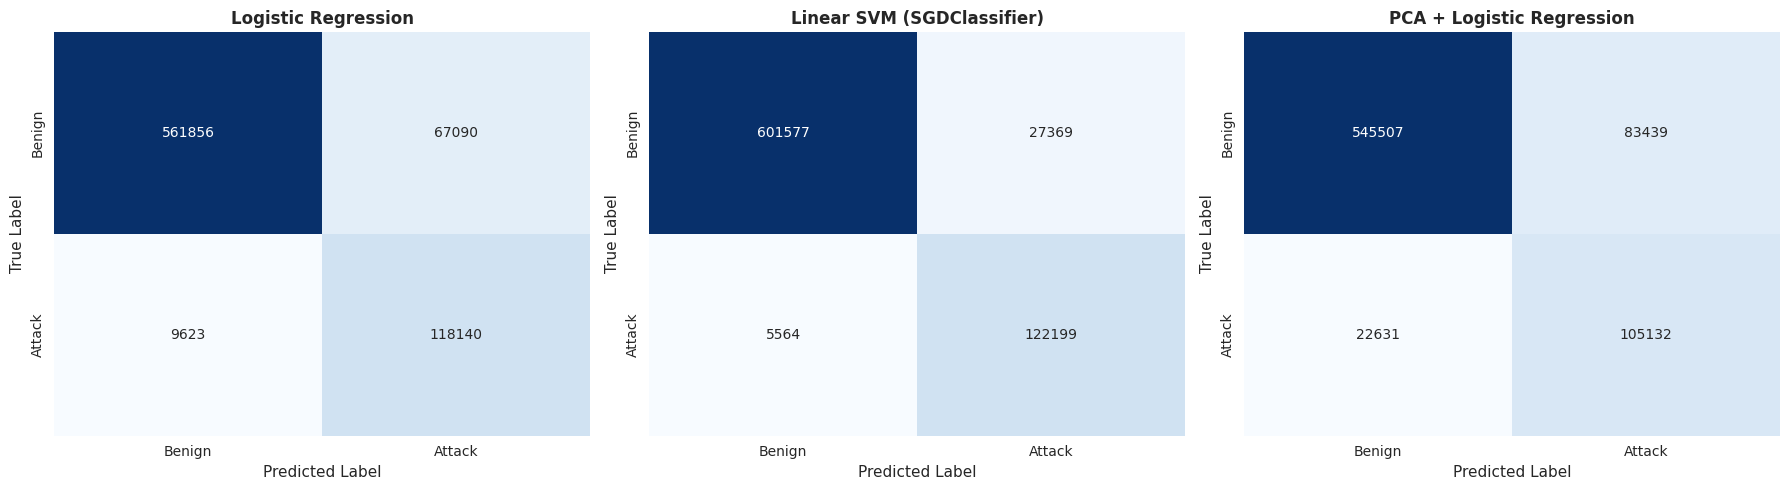

✓ Saved: outputs/confusion_matrices.png


In [49]:
# Compare Models
results = [lr_metrics, svm_metrics, pca_lr_metrics]
comparison_df_temp = pd.DataFrame(results).set_index('Model')
print("\nModel Comparison:")
print(comparison_df_temp)

# Plot Confusion Matrices with proper class labels
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
class_names = ['Benign', 'Attack']

for idx, (result, ax) in enumerate(zip(results, axes)):
    cm = np.array(result['Confusion Matrix'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f"{result['Model']}", fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.savefig(
    get_output_path('confusion_matrices.png'),
    dpi=300,
    bbox_inches='tight'
)
plt.show()
print("✓ Saved: outputs/confusion_matrices.png")

---
## 21b. ROC Curves

Visualize ROC curves for all models to assess their discrimination ability.


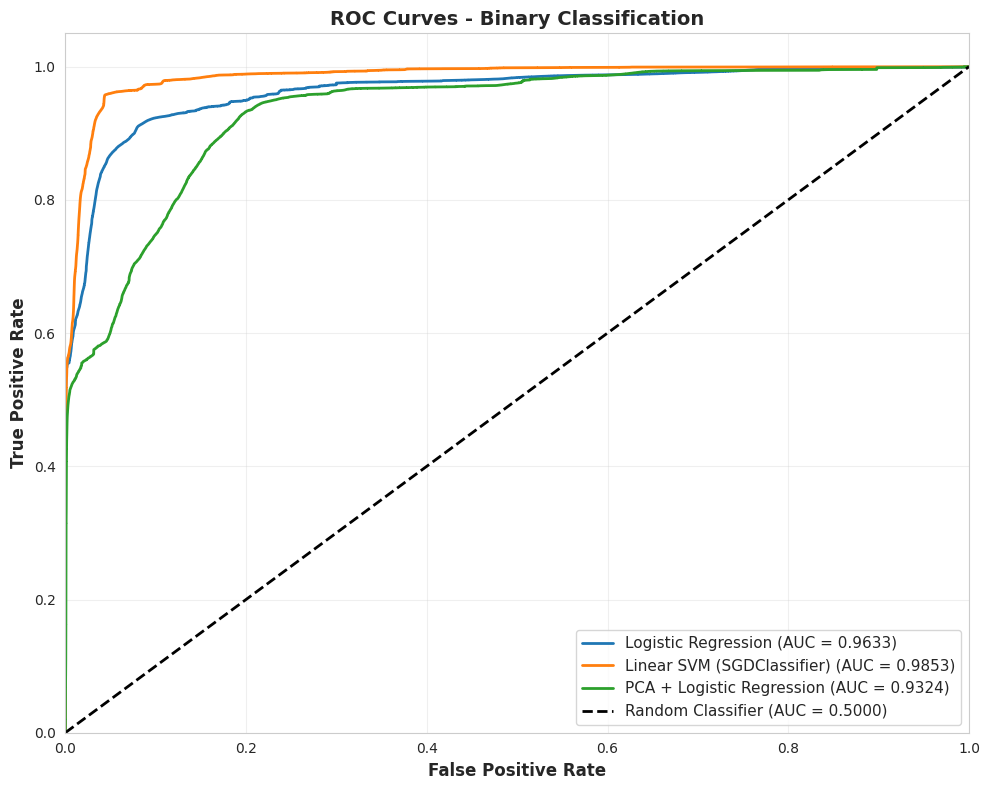

✓ Saved: outputs/roc_curves.png


In [50]:
# Plot ROC Curves for all models
fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC curve for each model
models_data = [
    (lr_model, 'Logistic Regression', X_test_lr),
    (svm_model, 'Linear SVM (SGDClassifier)', X_test_svm_scaled),
    (pca_lr_pipeline, 'PCA + Logistic Regression', X_test_pca_scaled)
]

for model, model_name, X_test_data in models_data:
    # Get predictions
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_data)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_data)
    else:
        continue

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Plot
    ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

# Plot diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5000)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - Binary Classification', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    get_output_path('roc_curves.png'),
    dpi=300,
    bbox_inches='tight'
)
plt.show()
print("✓ Saved: outputs/roc_curves.png")

---
## 21c. Prediction Distribution Analysis

Analyze the distribution of predicted probabilities vs actual labels for binary classification.

In [51]:
# Save model comparison table
comparison_df.to_csv(get_output_path('model_comparison.csv'), index=False)


✓ Prediction results generated for all models


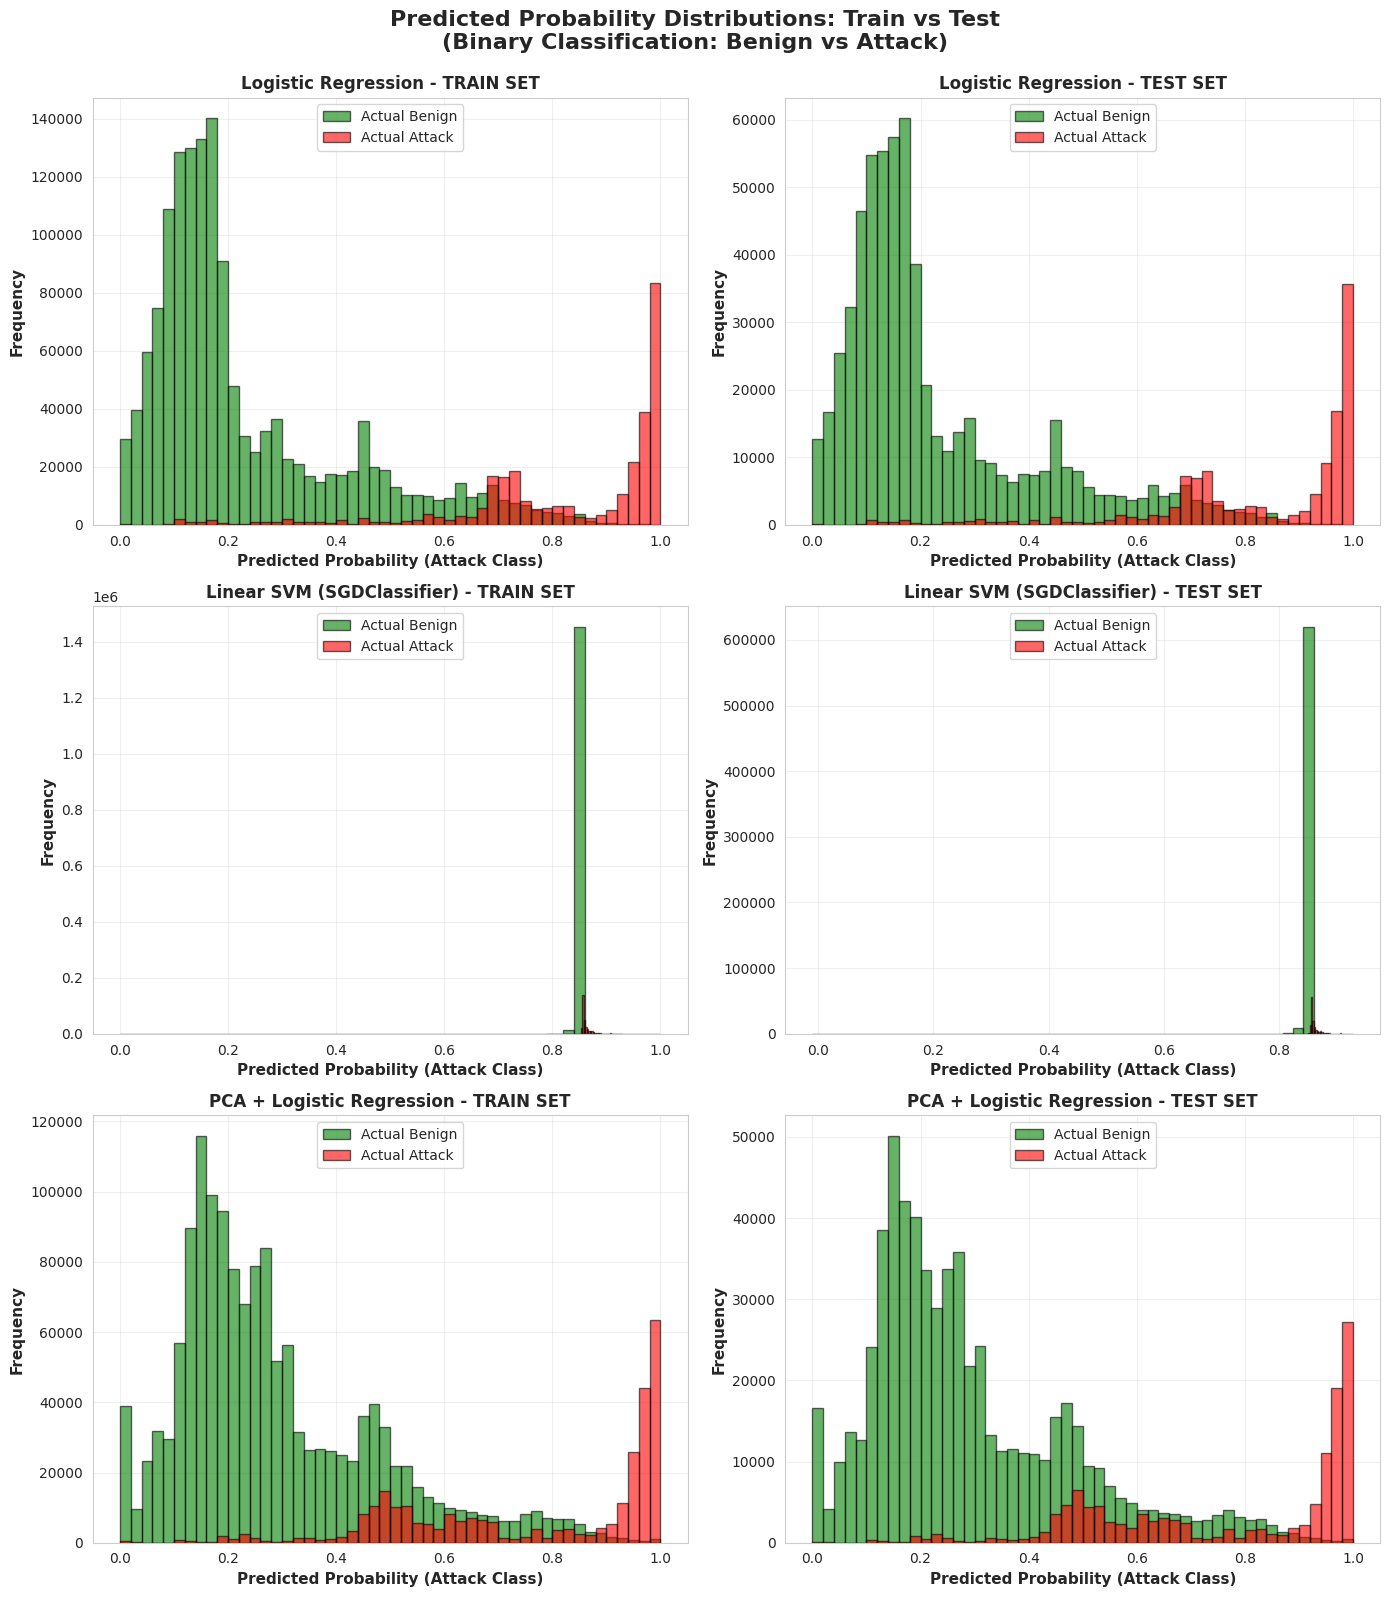

✓ Saved: outputs/prediction_distributions.png


In [53]:
# Generate prediction results for probability distribution analysis
prediction_results = {}

# Logistic Regression
lr_train_proba = lr_model.predict_proba(X_train_lr)[:, 1]
lr_test_proba = lr_model.predict_proba(X_test_lr)[:, 1]
prediction_results['Logistic Regression'] = {
    'train_proba': lr_train_proba,
    'train_actual': y_train,
    'test_proba': lr_test_proba,
    'test_actual': y_test
}

# Linear SVM (SGDClassifier)
svm_train_proba = svm_model.decision_function(X_train_svm_scaled)
svm_test_proba = svm_model.decision_function(X_test_svm_scaled)
# Normalize decision function to [0, 1] range
from sklearn.preprocessing import MinMaxScaler
scaler_svm_proba = MinMaxScaler()
svm_train_proba_norm = scaler_svm_proba.fit_transform(svm_train_proba.reshape(-1, 1)).ravel()
svm_test_proba_norm = scaler_svm_proba.transform(svm_test_proba.reshape(-1, 1)).ravel()
prediction_results['Linear SVM (SGDClassifier)'] = {
    'train_proba': svm_train_proba_norm,
    'train_actual': y_train,
    'test_proba': svm_test_proba_norm,
    'test_actual': y_test
}

# PCA + Logistic Regression
pca_lr_train_proba = pca_lr_pipeline.predict_proba(X_train_pca_scaled)[:, 1]
pca_lr_test_proba = pca_lr_pipeline.predict_proba(X_test_pca_scaled)[:, 1]
prediction_results['PCA + Logistic Regression'] = {
    'train_proba': pca_lr_train_proba,
    'train_actual': y_train,
    'test_proba': pca_lr_test_proba,
    'test_actual': y_test
}

print("✓ Prediction results generated for all models")

# Plot Probability Distribution for Binary Classification
fig, axes = plt.subplots(3, 2, figsize=(14, 16))
fig.suptitle('Predicted Probability Distributions: Train vs Test\n(Binary Classification: Benign vs Attack)',
             fontsize=16, fontweight='bold', y=0.995)

for idx, (model_name, results) in enumerate(prediction_results.items()):
    # Train set
    ax_train = axes[idx, 0]
    for class_val in [0, 1]:
        mask = results['train_actual'] == class_val
        label = 'Benign' if class_val == 0 else 'Attack'
        color = 'green' if class_val == 0 else 'red'
        ax_train.hist(results['train_proba'][mask], bins=50, alpha=0.6,
                     label=f'Actual {label}', color=color, edgecolor='black')

    ax_train.set_xlabel('Predicted Probability (Attack Class)', fontsize=11, fontweight='bold')
    ax_train.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax_train.set_title(f'{model_name} - TRAIN SET', fontsize=12, fontweight='bold')
    ax_train.legend(loc='upper center', fontsize=10)
    ax_train.grid(True, alpha=0.3)

    # Test set
    ax_test = axes[idx, 1]
    for class_val in [0, 1]:
        mask = results['test_actual'] == class_val
        label = 'Benign' if class_val == 0 else 'Attack'
        color = 'green' if class_val == 0 else 'red'
        ax_test.hist(results['test_proba'][mask], bins=50, alpha=0.6,
                    label=f'Actual {label}', color=color, edgecolor='black')

    ax_test.set_xlabel('Predicted Probability (Attack Class)', fontsize=11, fontweight='bold')
    ax_test.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax_test.set_title(f'{model_name} - TEST SET', fontsize=12, fontweight='bold')
    ax_test.legend(loc='upper center', fontsize=10)
    ax_test.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(get_output_path('prediction_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: outputs/prediction_distributions.png")

In [54]:
# Generate prediction results for probability distribution analysis
print("Generating prediction probabilities for all models...")

prediction_results = {}

# Logistic Regression predictions
print("  - Logistic Regression...")
y_train_proba_lr = lr_model.predict_proba(X_train_lr)[:, 1]
y_test_proba_lr = lr_model.predict_proba(X_test_lr)[:, 1]

prediction_results['Logistic Regression'] = {
    'train_proba': y_train_proba_lr,
    'train_actual': y_train,
    'test_proba': y_test_proba_lr,
    'test_actual': y_test
}

# Linear SVM predictions (using decision_function for binary classification)
print("  - Linear SVM (SGDClassifier)...")
y_train_proba_svm = svm_model.decision_function(X_train_svm_scaled)
y_test_proba_svm = svm_model.decision_function(X_test_svm_scaled)

prediction_results['Linear SVM (SGDClassifier)'] = {
    'train_proba': y_train_proba_svm,
    'train_actual': y_train,
    'test_proba': y_test_proba_svm,
    'test_actual': y_test
}

# PCA + Logistic Regression predictions
print("  - PCA + Logistic Regression...")
y_train_proba_pca = pca_lr_pipeline.predict_proba(X_train_pca_scaled)[:, 1]
y_test_proba_pca = pca_lr_pipeline.predict_proba(X_test_pca_scaled)[:, 1]

prediction_results['PCA + Logistic Regression'] = {
    'train_proba': y_train_proba_pca,
    'train_actual': y_train,
    'test_proba': y_test_proba_pca,
    'test_actual': y_test
}

print("\n✓ Prediction results prepared for distribution analysis")

Generating prediction probabilities for all models...
  - Logistic Regression...
  - Linear SVM (SGDClassifier)...
  - PCA + Logistic Regression...

✓ Prediction results prepared for distribution analysis


---
## 23. Cross-Validation

Perform 5-fold stratified cross-validation for all models to assess generalization performance.


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Setup stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For CV demonstration, use a sample of the training data to make it faster
# Sample 10% of training data for CV (still ~198K samples)
sample_size = int(len(X_train) * 0.1)
np.random.seed(42)
sample_indices = np.random.choice(len(X_train), size=sample_size, replace=False)

# Create sampled datasets
X_train_sample_lr = X_train_lr[sample_indices]
X_train_sample_svm = X_train_svm_scaled[sample_indices]
X_train_sample_pca = X_train_pca_scaled[sample_indices]
y_train_sample = y_train[sample_indices]

print(f"Performing 5-fold CV on sample of {sample_size:,} training samples...")
print("=" * 60)

# Models and associated TRAINING arrays
models = [
    (lr_model, 'Logistic Regression', X_train_sample_lr),
    (svm_model, 'Linear SVM', X_train_sample_svm),
    (pca_lr_pipeline, 'PCA + Logistic Regression', X_train_sample_pca)
]

cv_summary = []
for mdl, name, X in models:
    print(f"\nRunning CV for {name}...")
    scores = cross_val_score(mdl, X, y_train_sample, cv=cv, scoring='f1', n_jobs=-1)
    mean_f1 = scores.mean()
    std_f1 = scores.std()
    ci95 = std_f1 * 2
    cv_summary.append({'Model': name, 'Mean_F1': mean_f1, 'Std_F1': std_f1, 'CI_95': ci95})
    print(f"{name} CV Scores: {scores}")
    print(f"Mean F1: {mean_f1:.4f} (+/- {ci95:.4f})")

cv_df = pd.DataFrame(cv_summary)
print("\n" + "=" * 60)
print("\nCross-Validation Summary:")
print(cv_df.to_string(index=False))

# Save table
cv_df.to_csv(get_output_path('cv_results_table.csv'), index=False)
print("\n✓ Cross-validation table saved: outputs/cv_results_table.csv")

Running 3 CV jobs in parallel (outer jobs = 1); each CV runs folds single-threaded.


[Parallel(n_jobs=1)]: Done   0 out of   1 | elapsed:   17.9s remaining:   17.9s


KeyboardInterrupt: 

### Visualize Cross-Validation Results

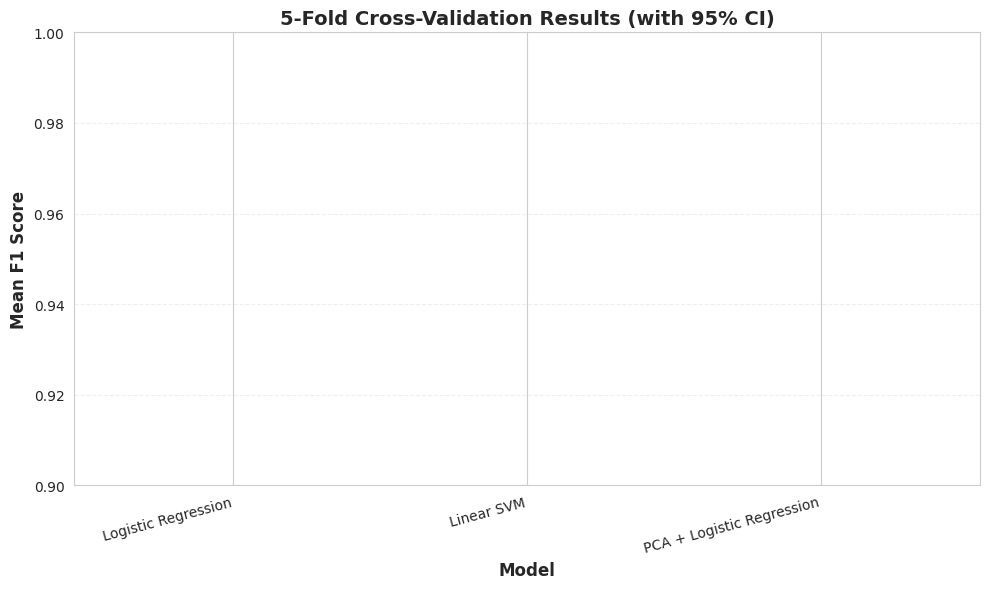


✓ Cross-validation plot saved as 'outputs/cv_results.png'


In [57]:
plt.figure(figsize=(10, 6))
models = cv_df['Model']
x_pos = np.arange(len(models))

plt.bar(x_pos, cv_df['Mean_F1'], yerr=cv_df['CI_95'], 
        capsize=10, color=['#2ecc71', '#3498db', '#e74c3c'], 
        alpha=0.7, edgecolor='black', linewidth=1.5)

plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Mean F1 Score', fontsize=12, fontweight='bold')
plt.title('5-Fold Cross-Validation Results (with 95% CI)', fontsize=14, fontweight='bold')
plt.xticks(x_pos, models, rotation=15, ha='right')
plt.ylim([0.9, 1.0])
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig(get_output_path('cv_results.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Cross-validation plot saved as 'outputs/cv_results.png'")